In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
import pandas.util.testing as tm

/Users/catair/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# acf and pacf function

def plot_acf_pacf(ts, zipcode, figsize=(10,8), lags = 12):
    fig,ax = plt.subplots(nrows=3, figsize = figsize)
    
    #plot time series
    ts.plot(ax=ax[0])
    
    #plot acf, pacf
    plot_acf(ts,ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    fig.tight_layout()
    
    fig.suptitle(f'Zipcode: {zipcode}',y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=lags, integer = True))
        a.xaxis.grid()
    return fig,ax

In [3]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [4]:
zips_grouped = pd.read_pickle("zips_grouped.pkl")
pred_roi_df = pd.read_pickle("pred_roi_df.pkl")
pred_roi_df

,zipcode,roi_2
0,78702.0,-2.475796


In [5]:
zip_78758 = zips_grouped.loc[78758]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78758,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1720.1211389405871
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1651.3736712648345
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1617.9151018105968
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1156.9621073321885
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1064.3266158630333
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =990.9555731317308
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =993.2632388750062
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =961.904344798505
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =938.2718737930197
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1118.113840798118
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1038.2770909581438
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1000.3092900744243
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1010.0199087215838
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =985.8694133398571
ARIMA (1, 1, 2) x (0, 0, 0,

pdq        (0, 2, 2)
pdqs    (0, 0, 0, 0)
aic          938.272
Name: 8, dtype: object

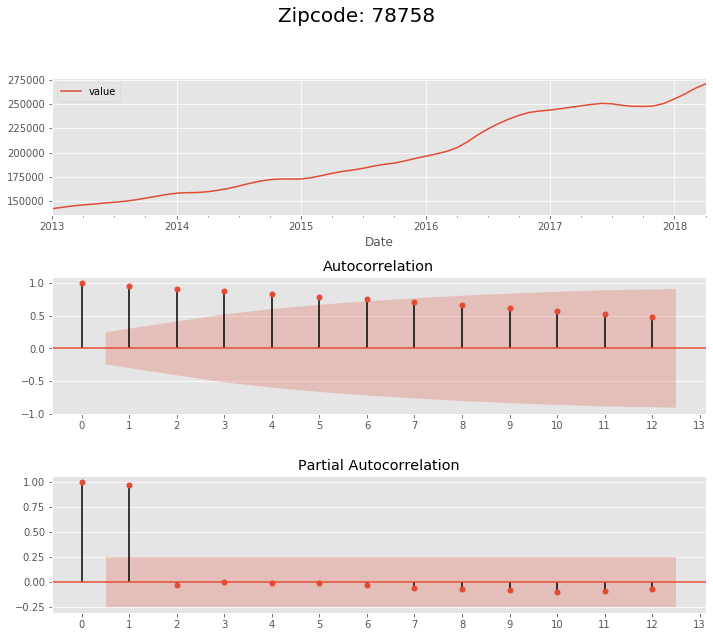

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8264      0.152      5.440      0.000       0.529       1.124
ma.L2          0.0984      0.135      0.731      0.465      -0.165       0.362
sigma2      4.302e+05   6.27e+04      6.865      0.000    3.07e+05    5.53e+05


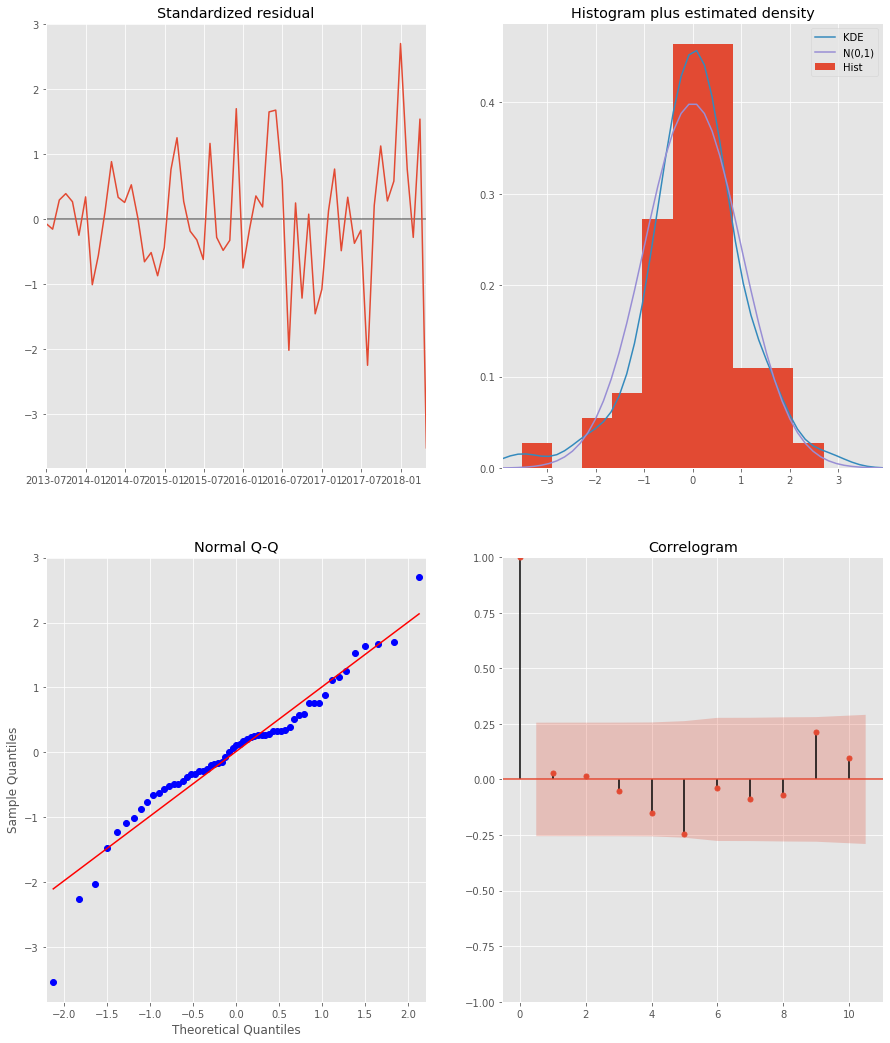

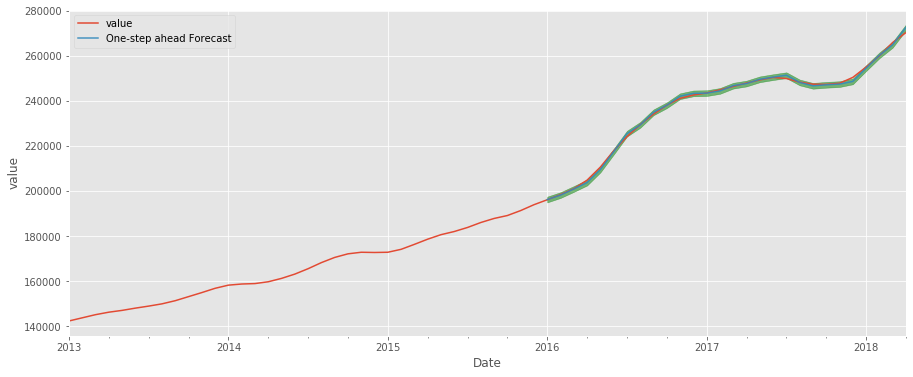

The Mean Squared Error of our forecasts is 701376.09


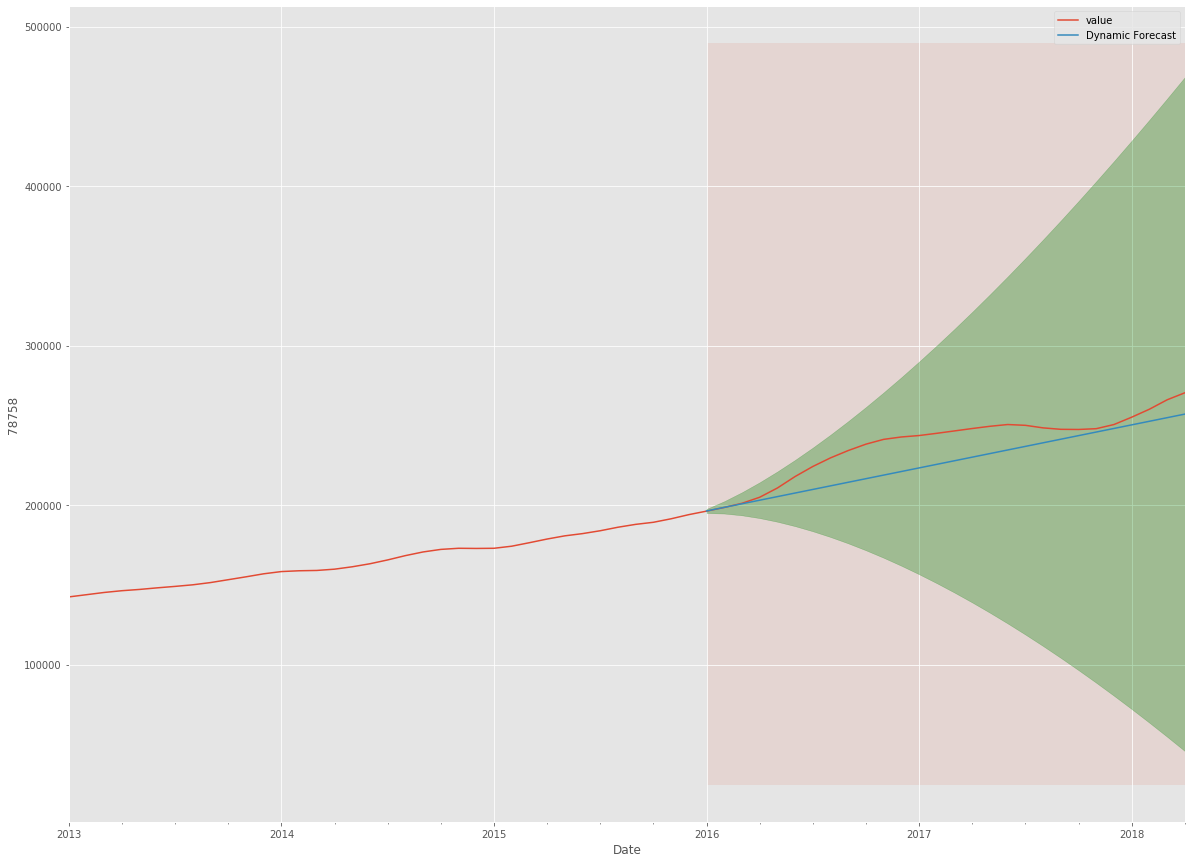

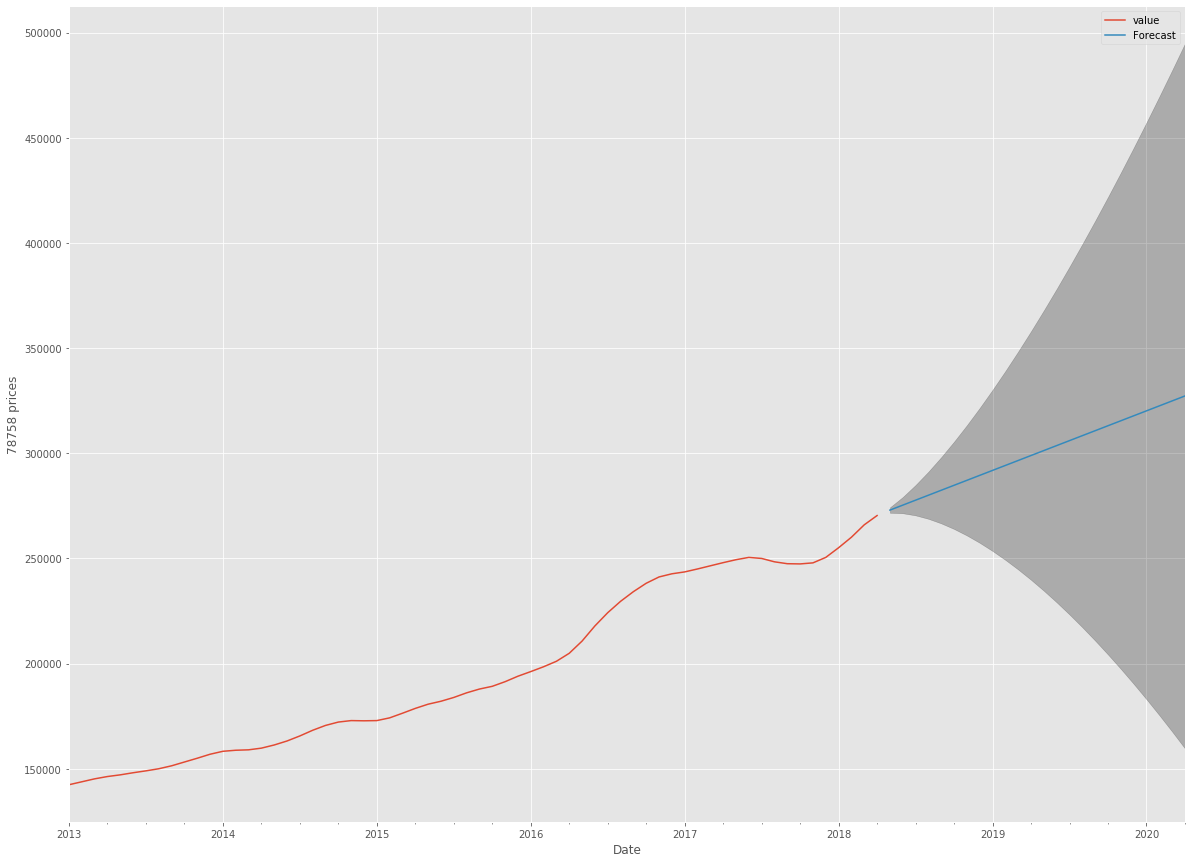

In [6]:
# acf, pacf
plot_acf_pacf(zip_78758, 78758)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78758, 
                                        order=(0, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78758['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78758_forecasted = pred.predicted_mean
zip_78758_truth = zip_78758['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78758_forecasted - zip_78758_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78758['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78758_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78758')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78758.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78758 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78758, roi_2] 

In [11]:
zip_78702 = zips_grouped.loc[78702]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78702,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1784.2276945951512
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1714.5008344688117
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1680.4254516196747
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1186.0151958254141
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1114.4143529770304
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =1019.9336829382637
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =1047.2291849042276
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =1021.5712030769623
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =992.0594330146955
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1127.3368814658709
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1048.2789980146158
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1001.9113978426942
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1063.4632846460252
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1044.288010426315
ARIMA (1, 1, 2) x (0, 

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic          972.398
Name: 26, dtype: object

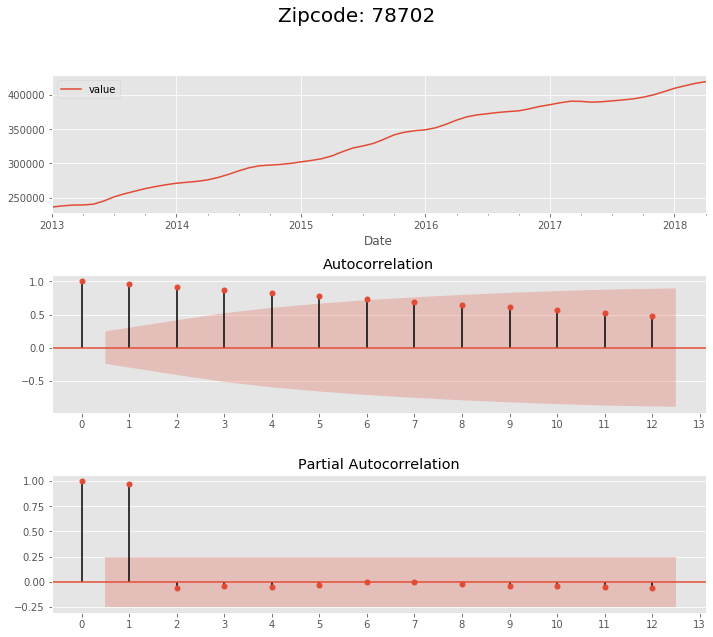

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3939      0.201      1.964      0.050       0.001       0.787
ar.L2         -0.5092      0.109     -4.664      0.000      -0.723      -0.295
ma.L1          0.3418      0.203      1.682      0.093      -0.056       0.740
ma.L2          0.0496      0.123      0.404      0.686      -0.191       0.290
sigma2      6.901e+05   1.61e+05      4.283      0.000    3.74e+05    1.01e+06


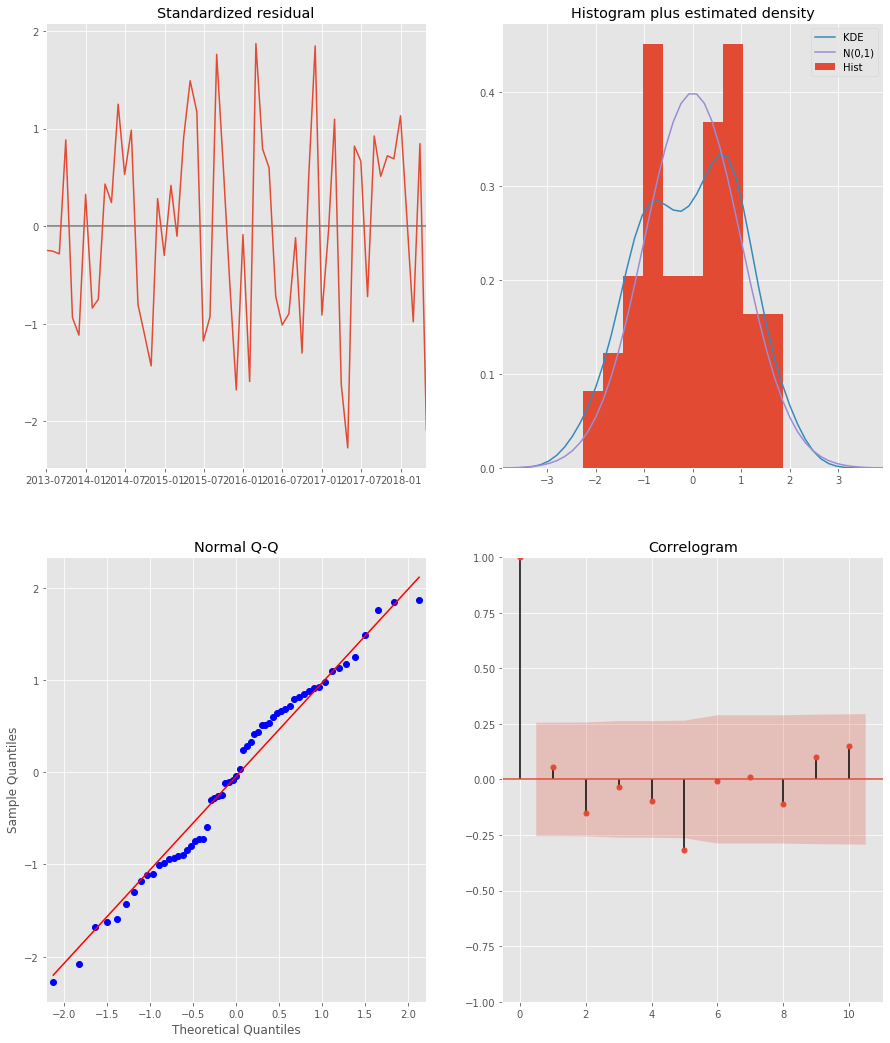

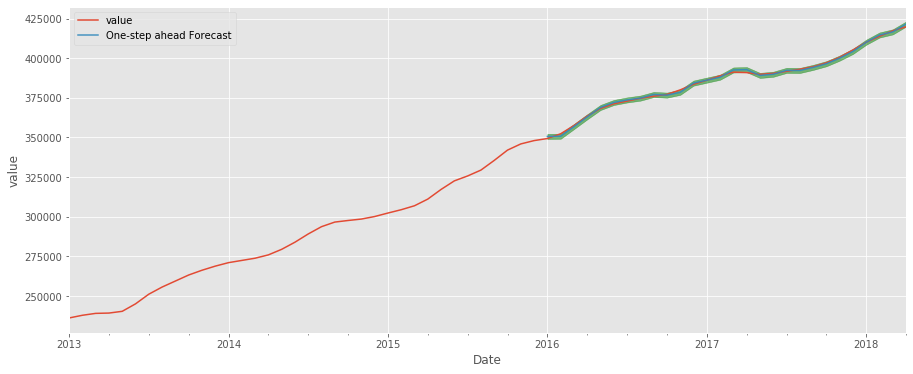

The Mean Squared Error of our forecasts is 877002.85


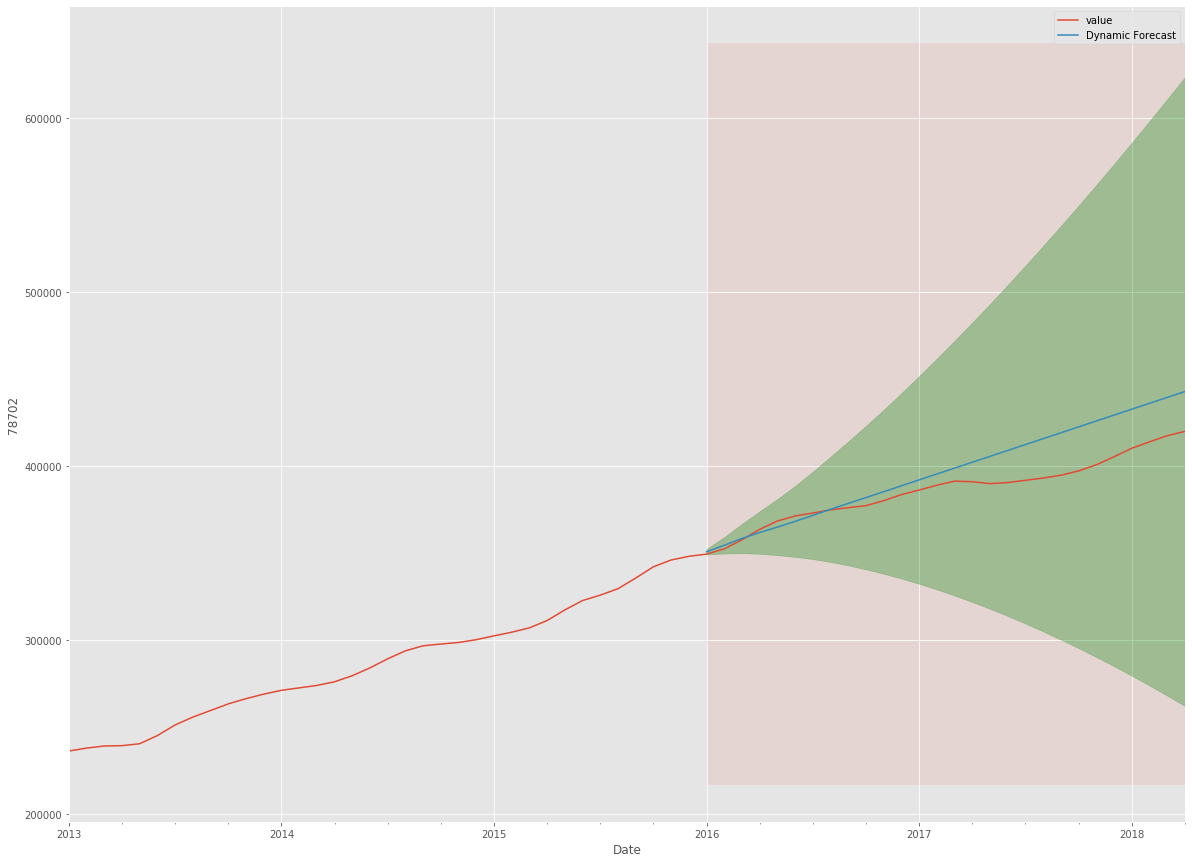

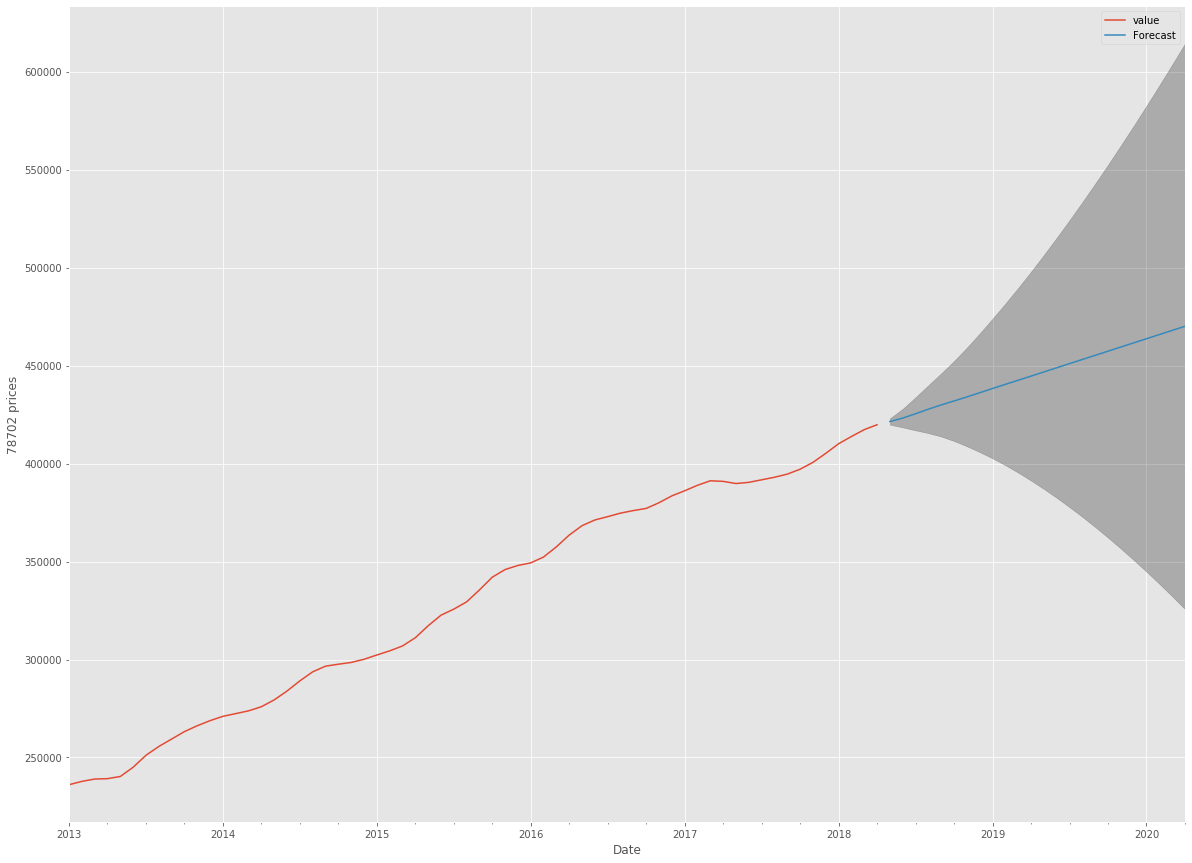

In [12]:
# acf, pacf
plot_acf_pacf(zip_78702, 78702)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78702, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78702['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78702_forecasted = pred.predicted_mean
zip_78702_truth = zip_78702['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78702_forecasted - zip_78702_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78702['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78702_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78702')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78702.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78702 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78702, roi_2] 

In [13]:
zip_78744 = zips_grouped.loc[78744]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78744,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1681.4023145478507
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1613.2852967991987
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1580.4383401029559
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1097.160189526098
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1014.2796119762063
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =941.1321091528769
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =976.606010829521
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =952.1609062359811
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =929.0509065434819
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1038.4637350643732
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =973.9442784733698
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =927.5492470616625
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =990.8738267084483
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =968.5652022491026
ARIMA (1, 1, 2) x (0, 0, 0, 0)

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic          924.786
Name: 26, dtype: object

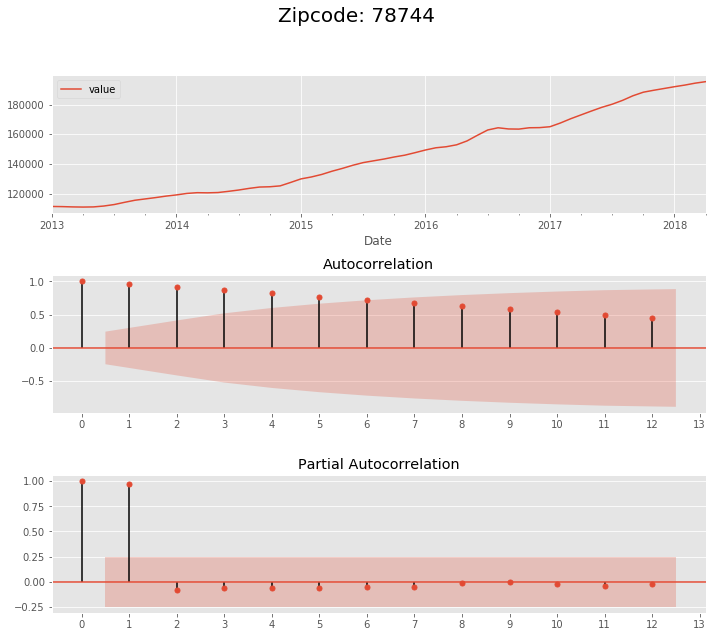

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1909      0.163      1.173      0.241      -0.128       0.510
ar.L2         -0.5531      0.101     -5.469      0.000      -0.751      -0.355
ma.L1          0.3084      0.188      1.639      0.101      -0.060       0.677
ma.L2          0.0499      0.109      0.456      0.648      -0.164       0.264
sigma2      3.021e+05   5.66e+04      5.334      0.000    1.91e+05    4.13e+05


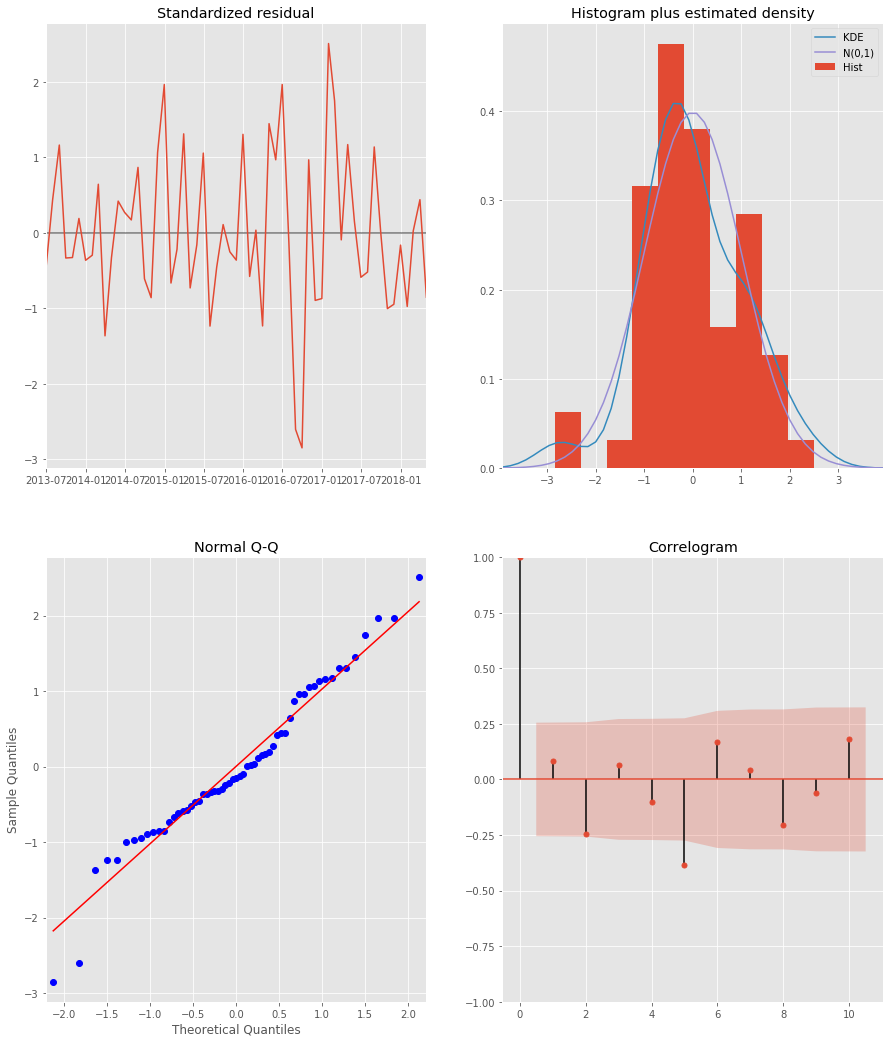

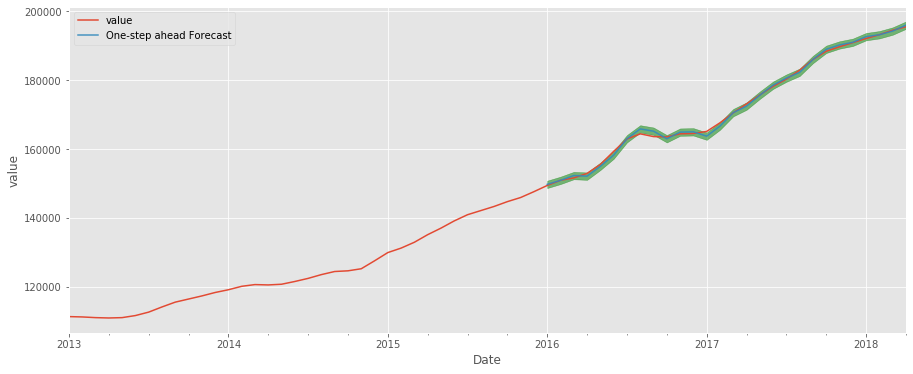

The Mean Squared Error of our forecasts is 459447.22


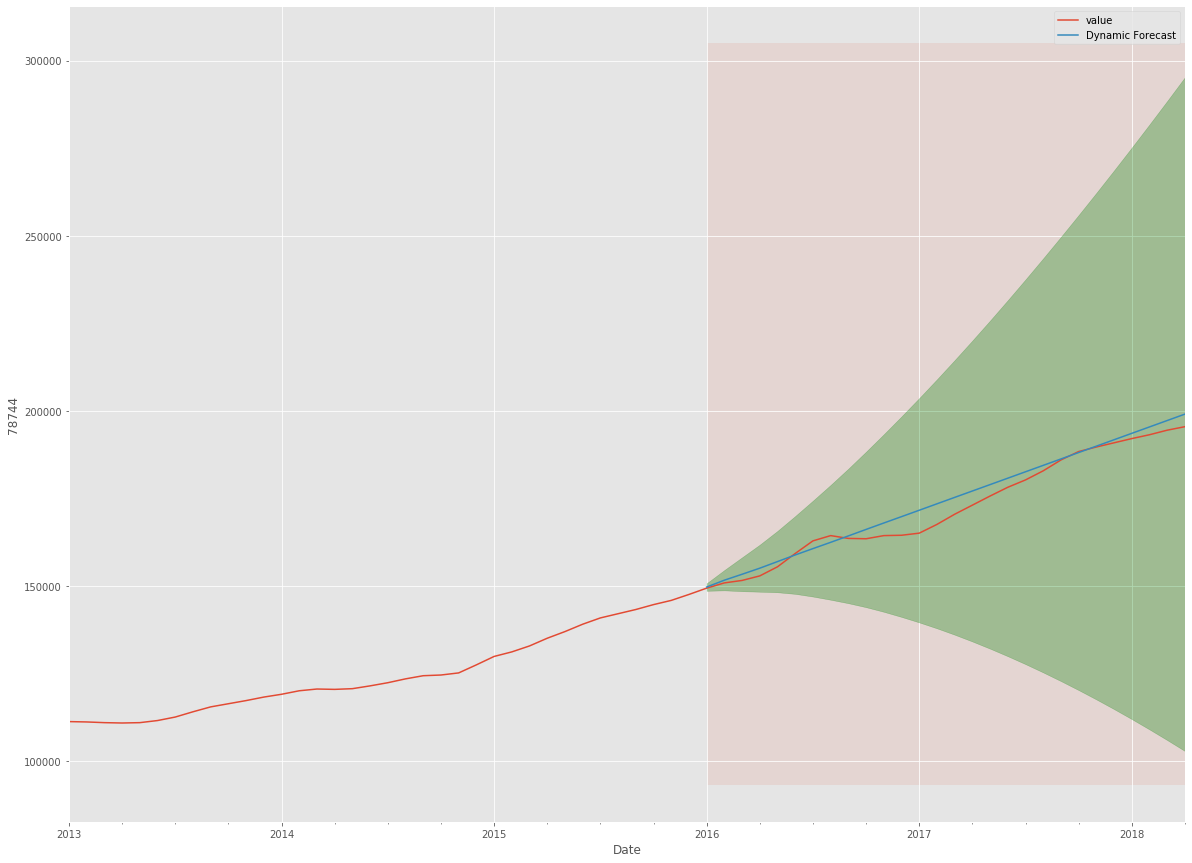

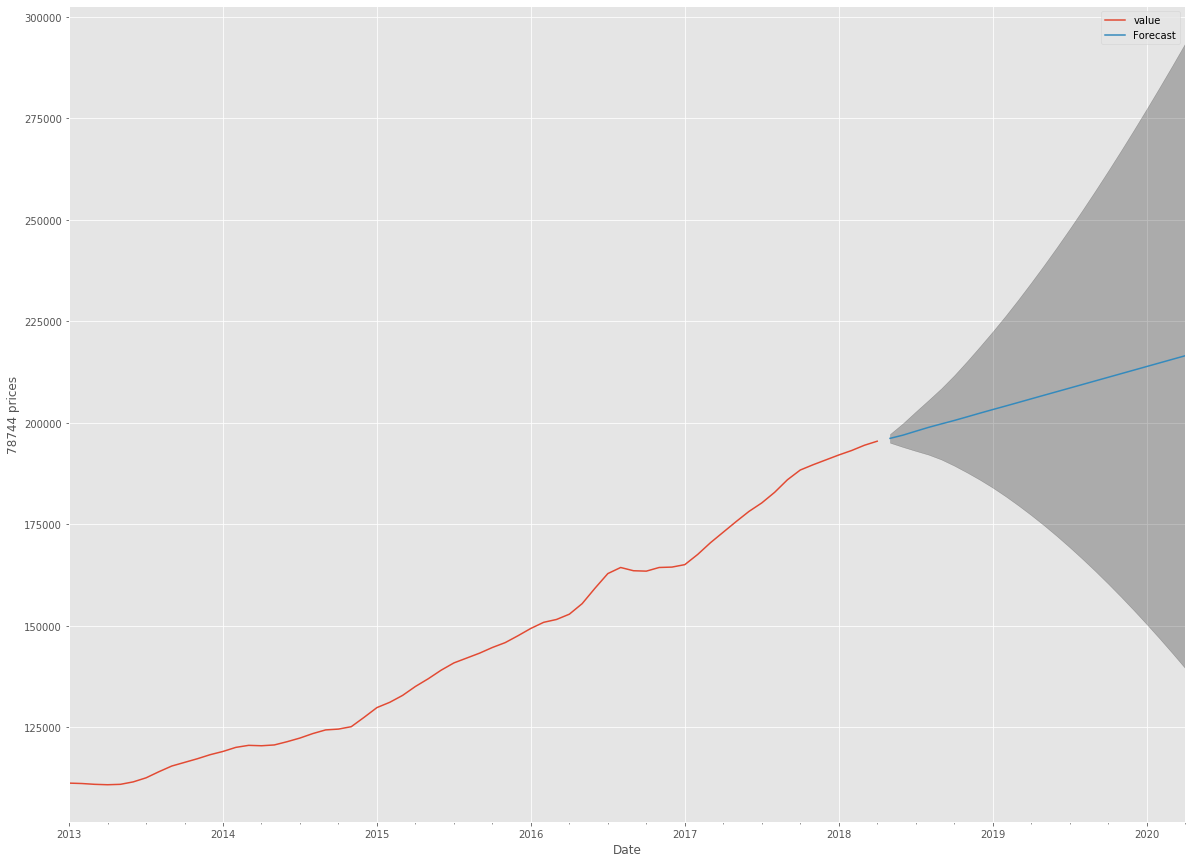

In [14]:
# acf, pacf
plot_acf_pacf(zip_78744, 78744)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78744, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78744['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78744_forecasted = pred.predicted_mean
zip_78744_truth = zip_78744['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78744_forecasted - zip_78744_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78744['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78744_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78744')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78744.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78744 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78744, roi_2] 

In [15]:
zip_78741 = zips_grouped.loc[78741]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78741,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1713.822447111103
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1645.2004438825134
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1611.86467338756
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1137.8493696079709
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1053.6602926636197
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =987.4503075812219
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =1013.0199924907107
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =990.730477013881
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =968.4811575672584
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1099.4726748492817
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1031.847730210436
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =984.1420533359319
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1028.6216054392007
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1007.9360322450266
ARIMA (1, 1, 2) x (0, 0, 0, 0

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic           964.73
Name: 26, dtype: object

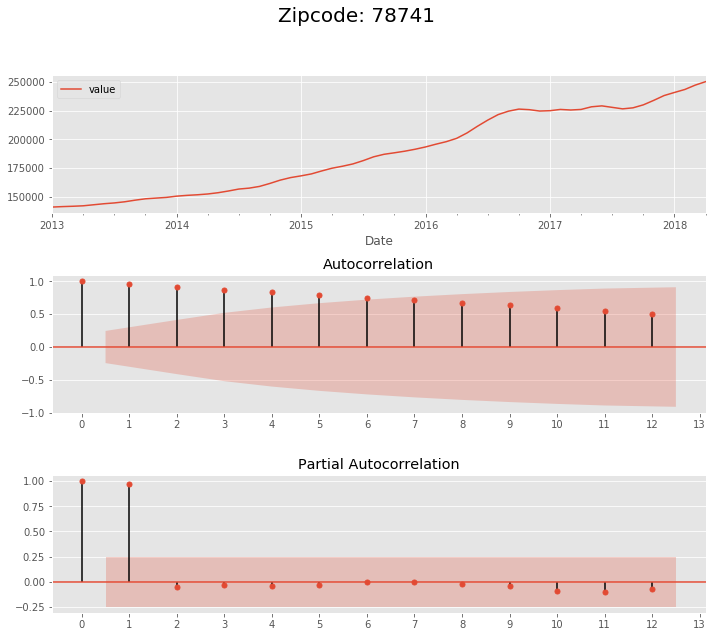

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2705      0.249      1.087      0.277      -0.217       0.758
ar.L2         -0.5209      0.139     -3.737      0.000      -0.794      -0.248
ma.L1          0.2671      0.316      0.847      0.397      -0.351       0.885
ma.L2          0.0628      0.152      0.413      0.679      -0.235       0.361
sigma2       6.65e+05   1.22e+05      5.445      0.000    4.26e+05    9.04e+05


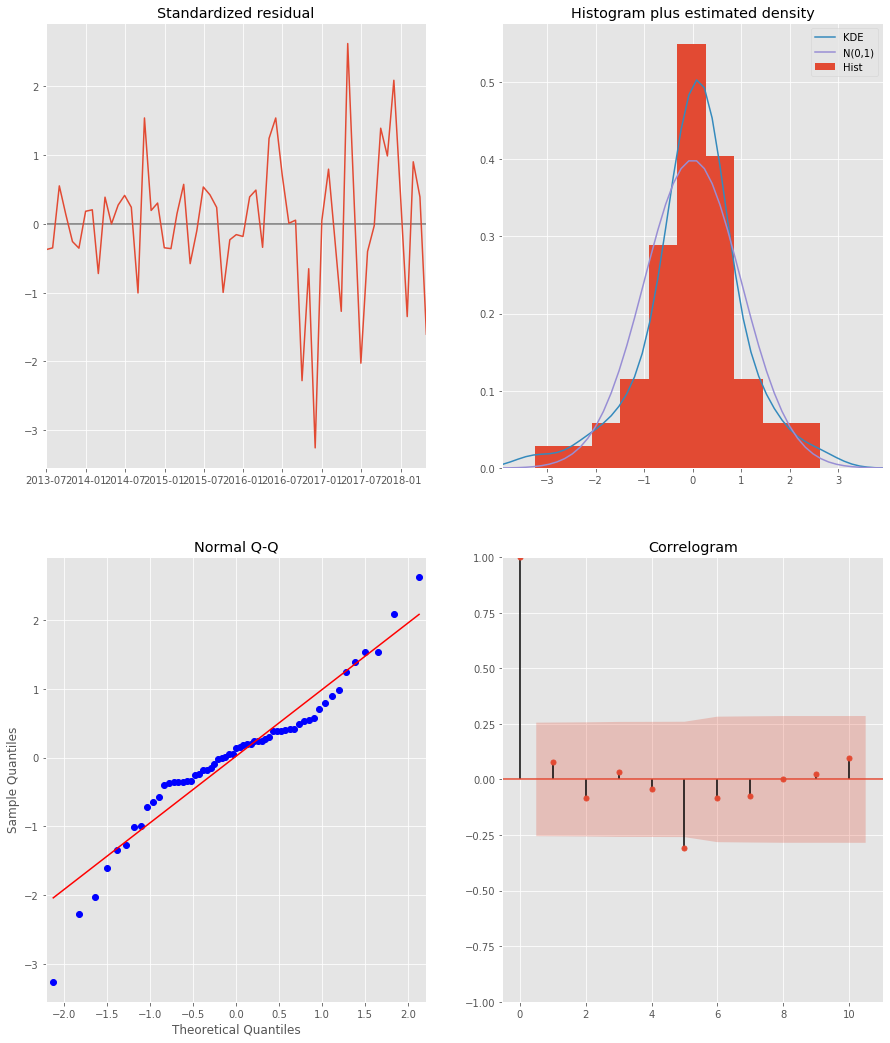

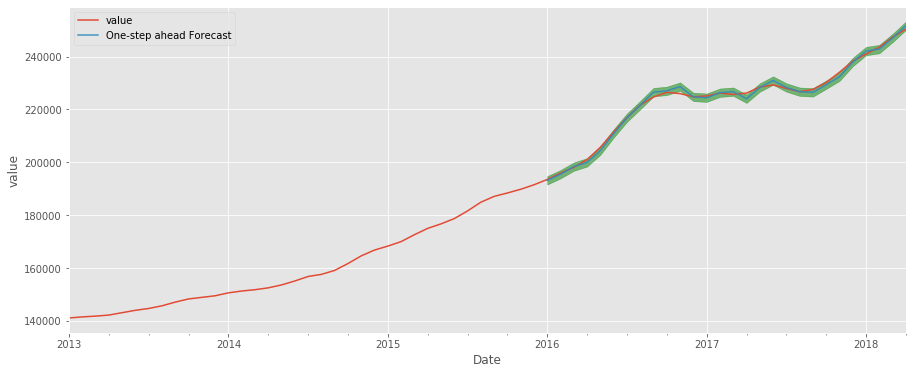

The Mean Squared Error of our forecasts is 1124556.08


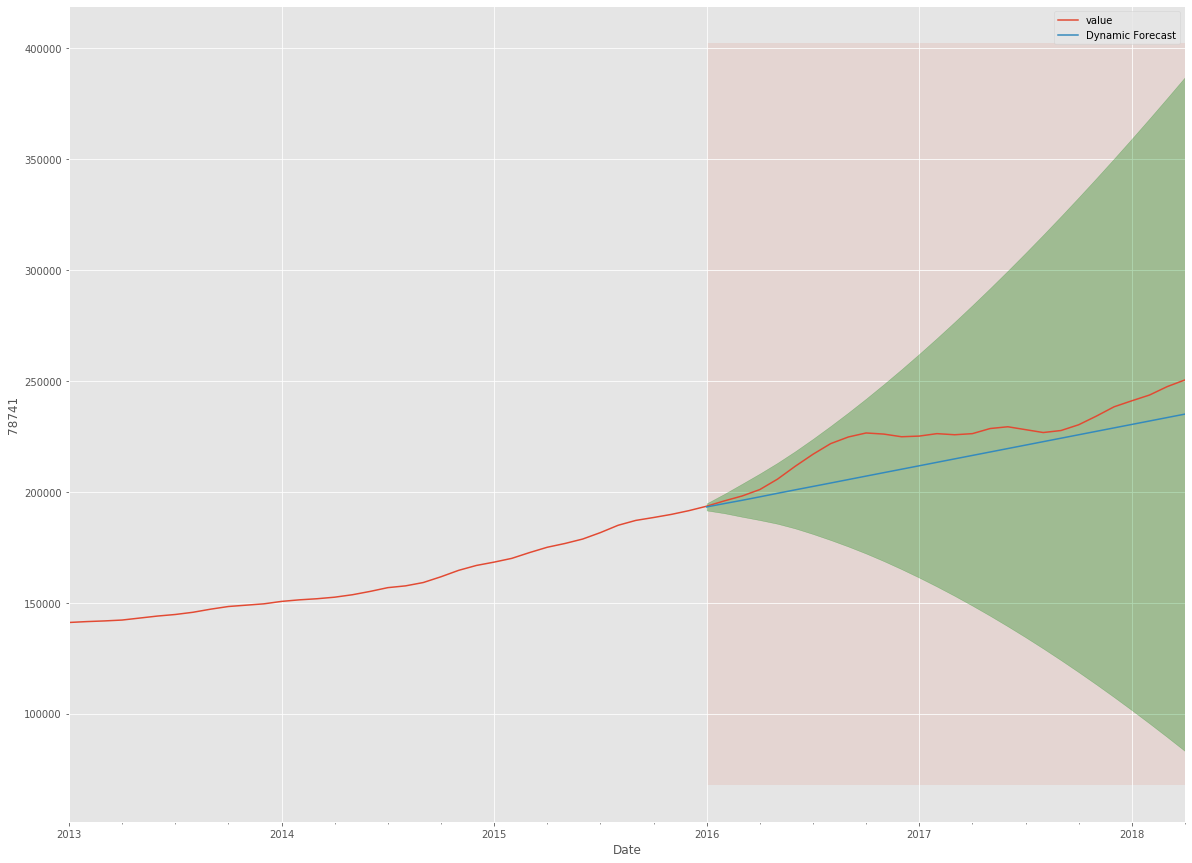

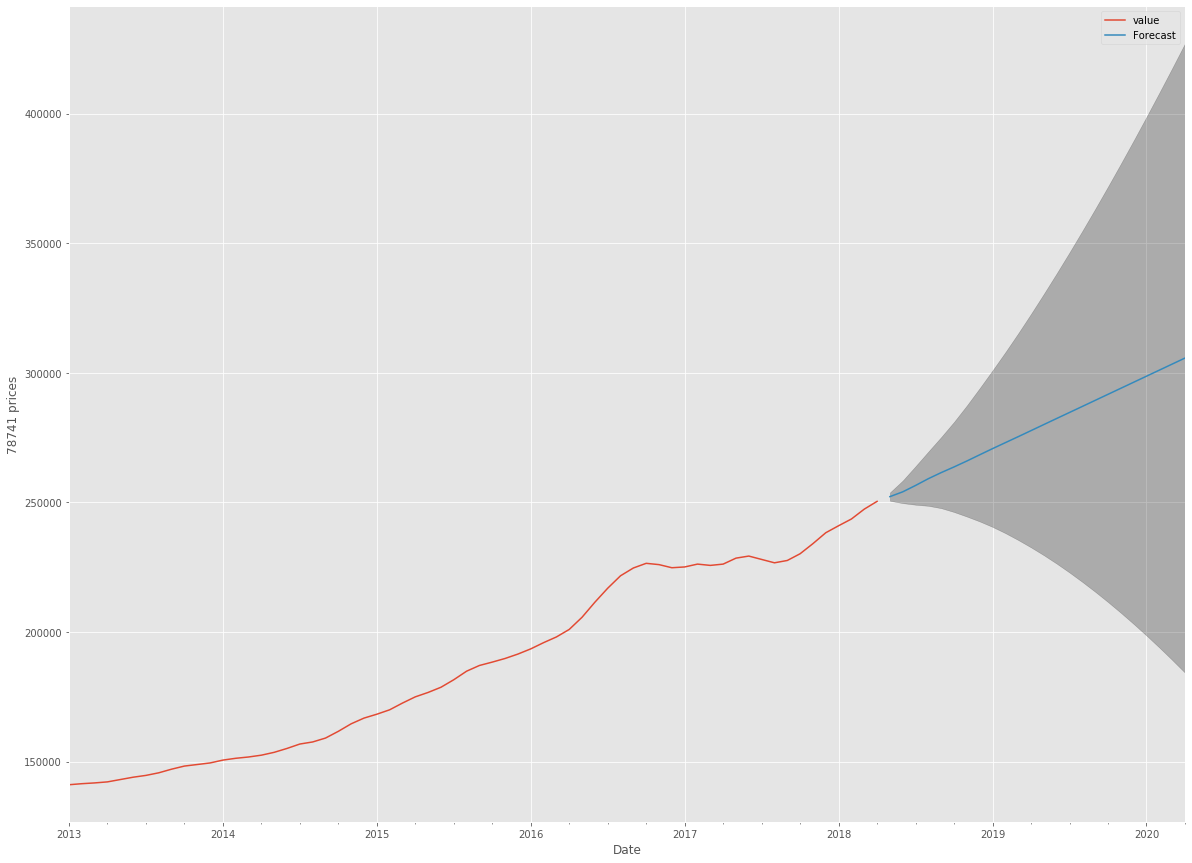

In [16]:
# acf, pacf
plot_acf_pacf(zip_78741, 78741)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78741, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78741['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78741_forecasted = pred.predicted_mean
zip_78741_truth = zip_78741['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78741_forecasted - zip_78741_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78741['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78741_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78741')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78741.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78741 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78741, roi_2] 

In [17]:
zip_78753 = zips_grouped.loc[78753]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78753,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1706.1507611944319
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1637.588288387589
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1604.2025364276071
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1114.7255703031396
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1028.0558221815477
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =964.3769966732264
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =965.9310916967155
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =942.1744417258664
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =926.9461039789556
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1054.0098502332285
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =988.0715005370938
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =955.036220269189
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =981.3121257265655
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =959.0766106332026
ARIMA (1, 1, 2) x (0, 0, 0, 0)

pdq        (1, 2, 2)
pdqs    (0, 0, 0, 0)
aic          923.688
Name: 17, dtype: object

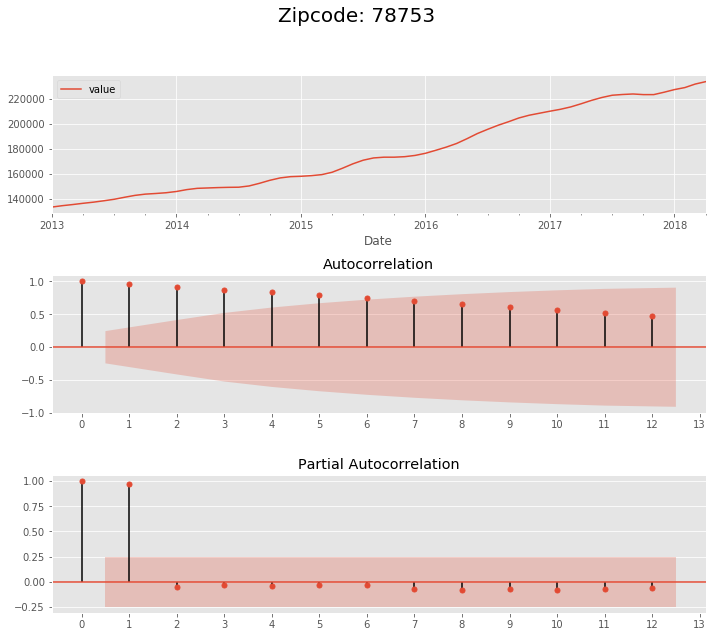

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6974      0.083      8.359      0.000       0.534       0.861
ma.L1         -0.5189      0.451     -1.151      0.250      -1.403       0.365
ma.L2         -0.4865      0.157     -3.103      0.002      -0.794      -0.179
sigma2       2.96e+05   1.34e+05      2.209      0.027    3.34e+04    5.59e+05


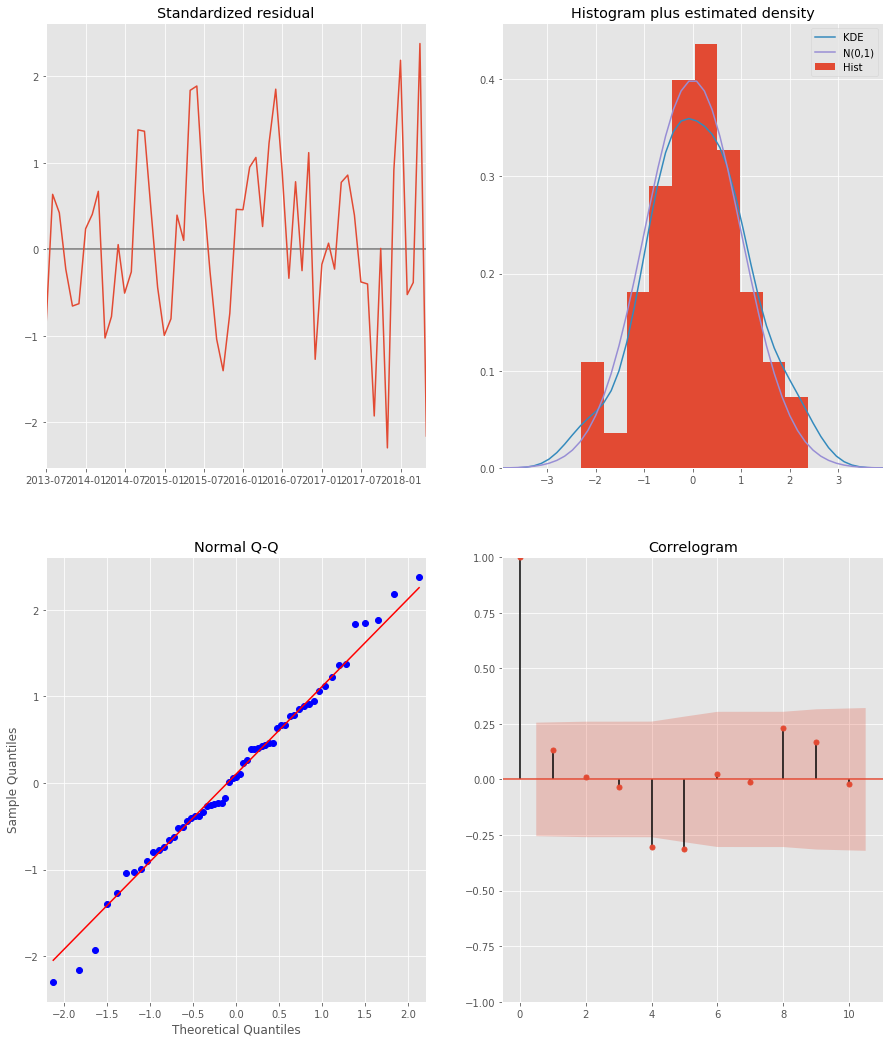

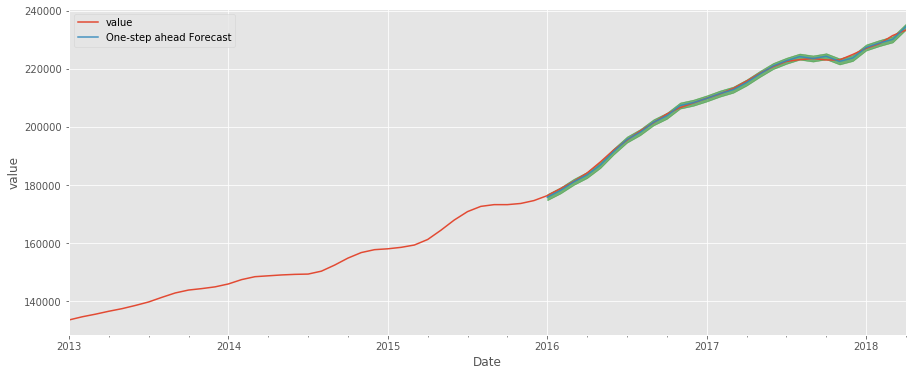

The Mean Squared Error of our forecasts is 418312.83


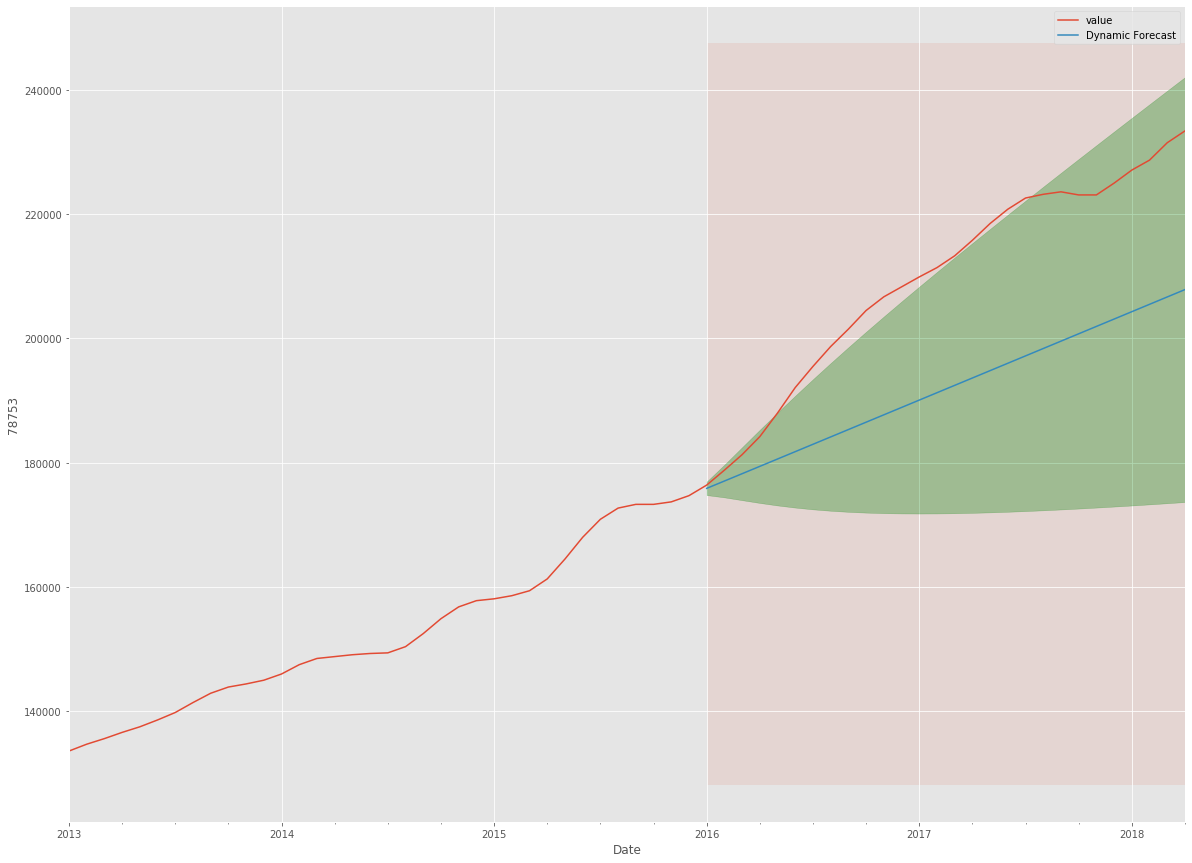

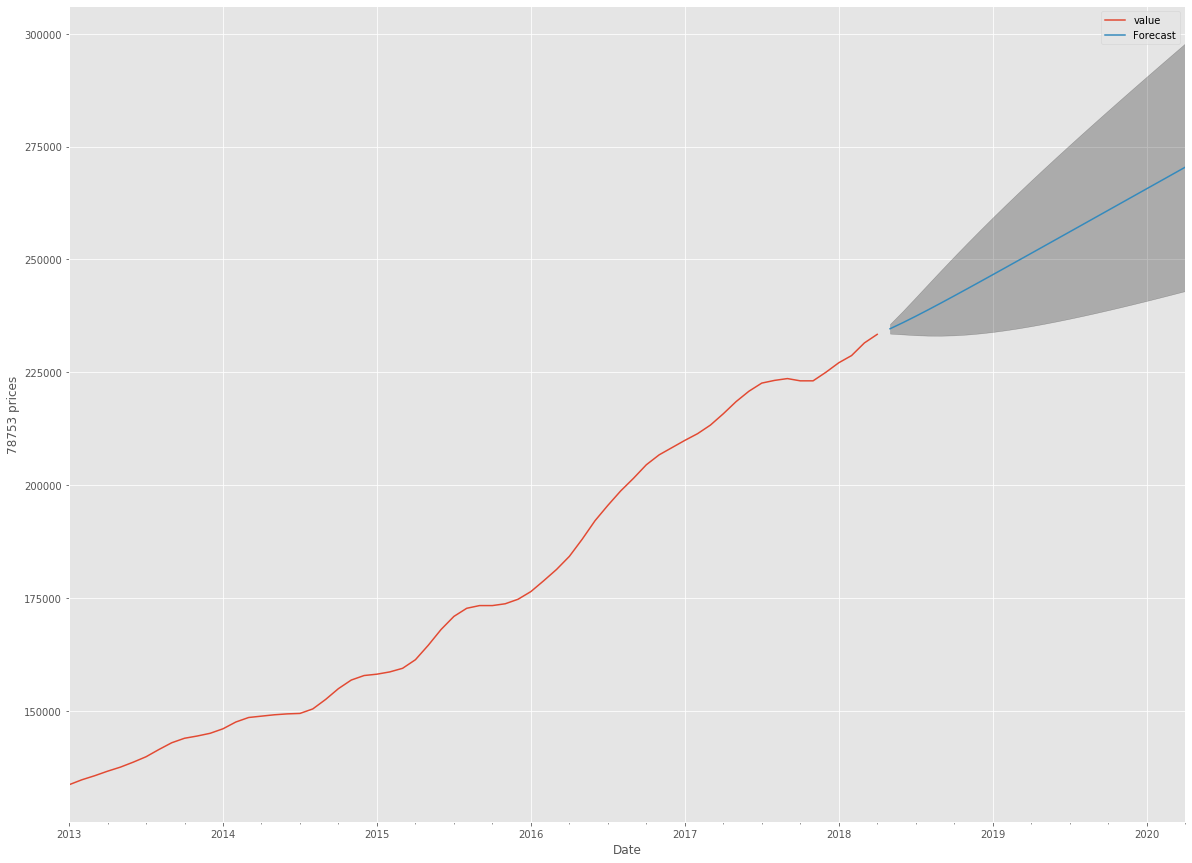

In [18]:
# acf, pacf
plot_acf_pacf(zip_78753, 78753)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78753, 
                                        order=(1, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78753['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78753_forecasted = pred.predicted_mean
zip_78753_truth = zip_78753['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78753_forecasted - zip_78753_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78753['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78753_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78753')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78753.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78753 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78753, roi_2] 

In [19]:
zip_78724 = zips_grouped.loc[78724]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78724,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1681.500871077919
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1613.303411846456
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =9746.041894115982
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1099.786750005836
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1008.7788999016176
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =939.9202101730964
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =958.225815583248
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =929.5066271159269
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =906.0657733024639
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1066.9663643006654
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =993.1118150259543
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =928.972126958934
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =972.9677383759897
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =943.8565918982557
ARIMA (1, 1, 2) x (0, 0, 0, 0)12 :

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic          904.018
Name: 26, dtype: object

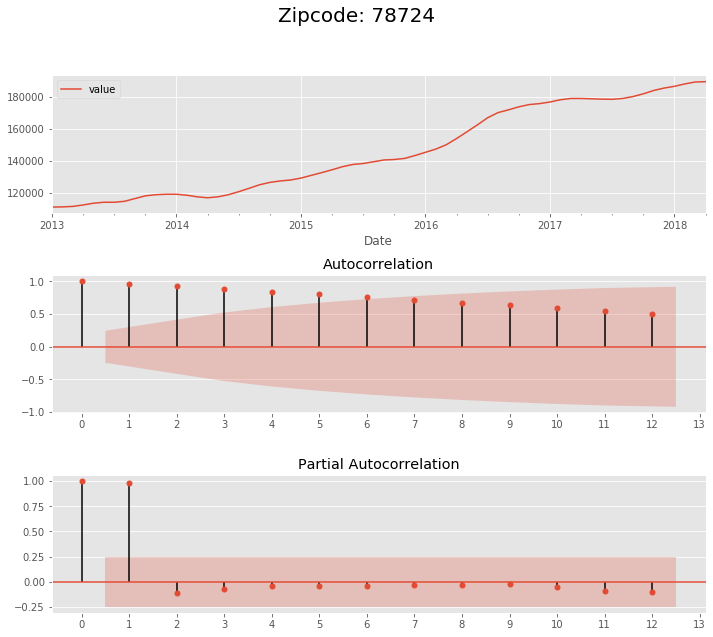

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5317      0.185     -2.870      0.004      -0.895      -0.169
ar.L2         -0.1316      0.024     -5.568      0.000      -0.178      -0.085
ma.L1          1.5085      0.159      9.513      0.000       1.198       1.819
ma.L2          0.7426      0.154      4.811      0.000       0.440       1.045
sigma2      2.559e+05   6.51e+04      3.930      0.000    1.28e+05    3.84e+05


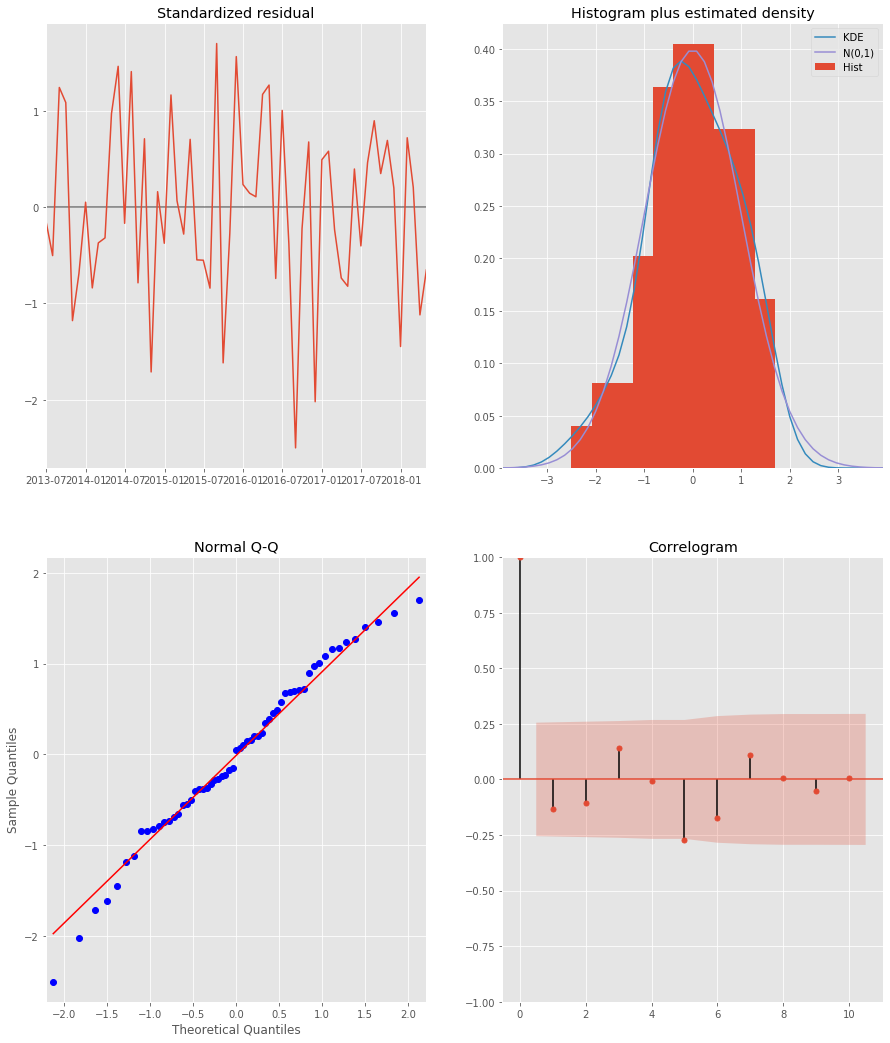

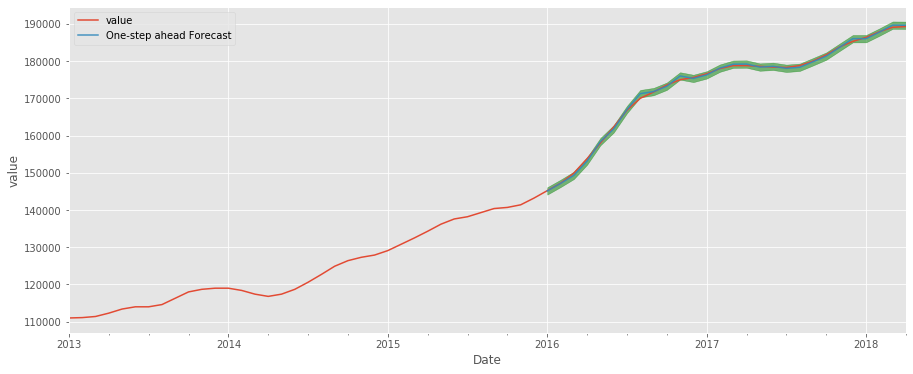

The Mean Squared Error of our forecasts is 216463.46


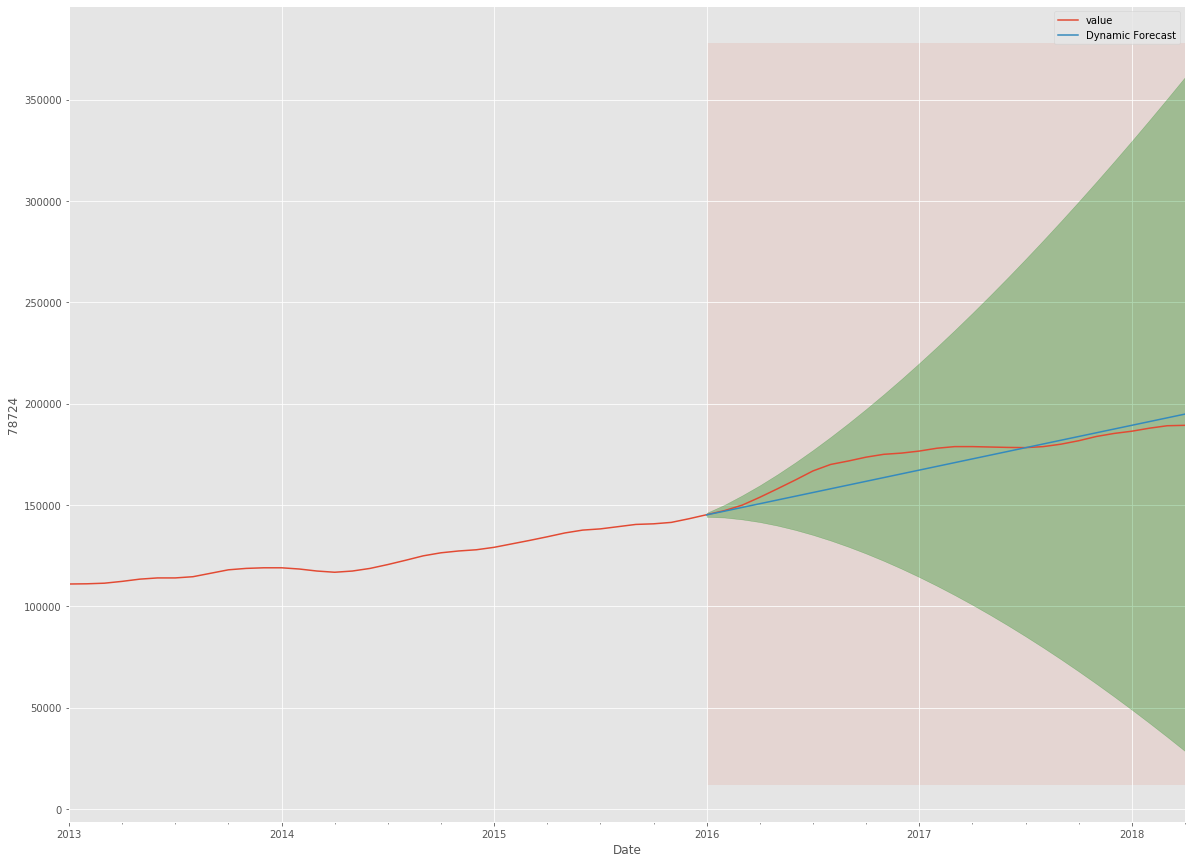

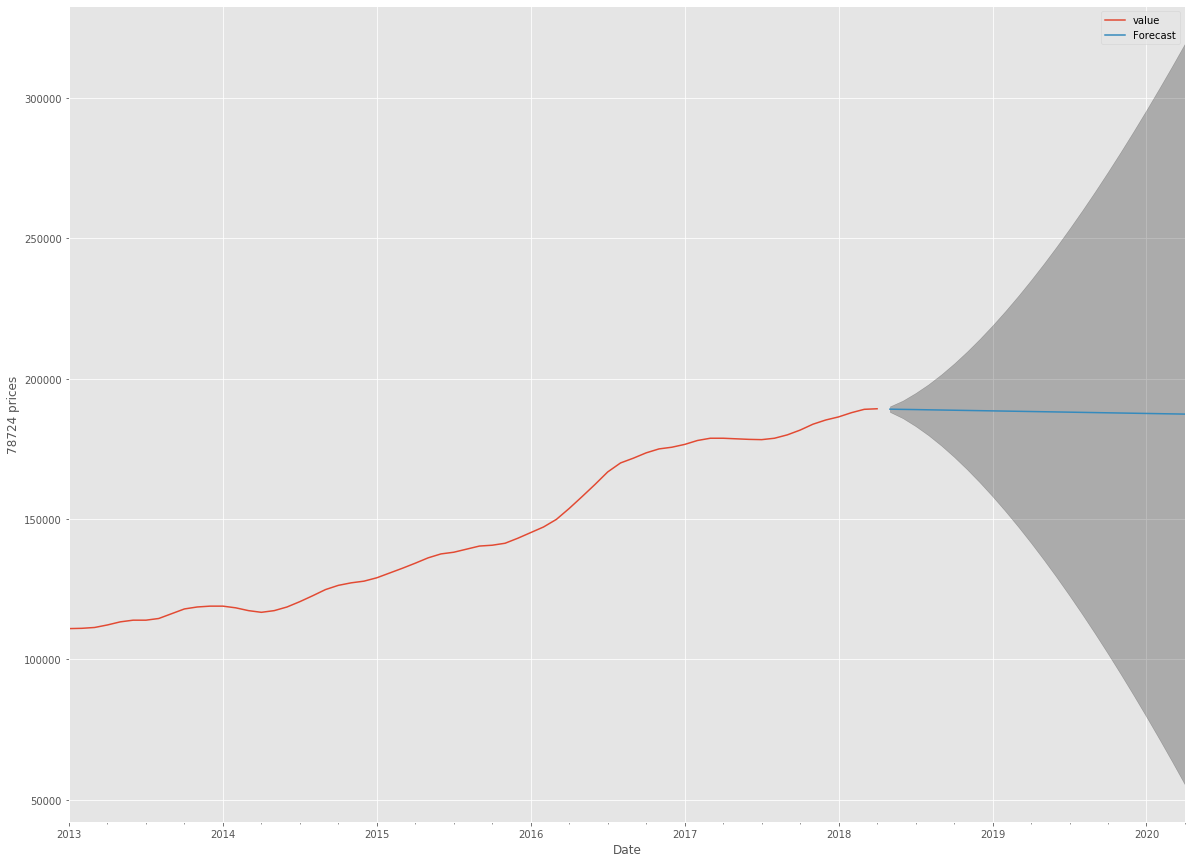

In [20]:
# acf, pacf
plot_acf_pacf(zip_78724, 78724)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78724, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78724['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78724_forecasted = pred.predicted_mean
zip_78724_truth = zip_78724['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78724_forecasted - zip_78724_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78724['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78724_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78724')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78724.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78724 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78724, roi_2] 

In [22]:
zip_78723 = zips_grouped.loc[78723]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78723,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1766.0289173867675
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1696.4875851247941
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1661.8360178549992
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1159.508413114163
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1064.8930929946046
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =1008.7848877702012
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =995.4966194630468
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =968.3368365688965
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =938.1895751356839
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1102.3020414529044
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1014.3605775933589
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =958.4092055166353
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1009.7651931414409
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =988.0003126554709
ARIMA (1, 1, 2) x (0, 0, 0

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic          935.949
Name: 26, dtype: object

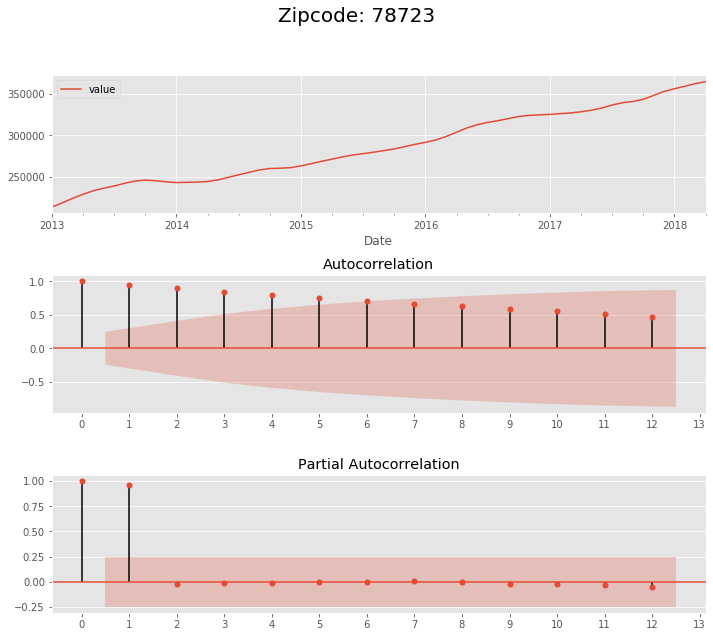

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5043      0.154      3.281      0.001       0.203       0.806
ar.L2         -0.5492      0.129     -4.252      0.000      -0.802      -0.296
ma.L1          0.2164      0.161      1.346      0.178      -0.099       0.532
ma.L2          0.0759      0.056      1.360      0.174      -0.033       0.185
sigma2      3.579e+05   7.54e+04      4.744      0.000     2.1e+05    5.06e+05


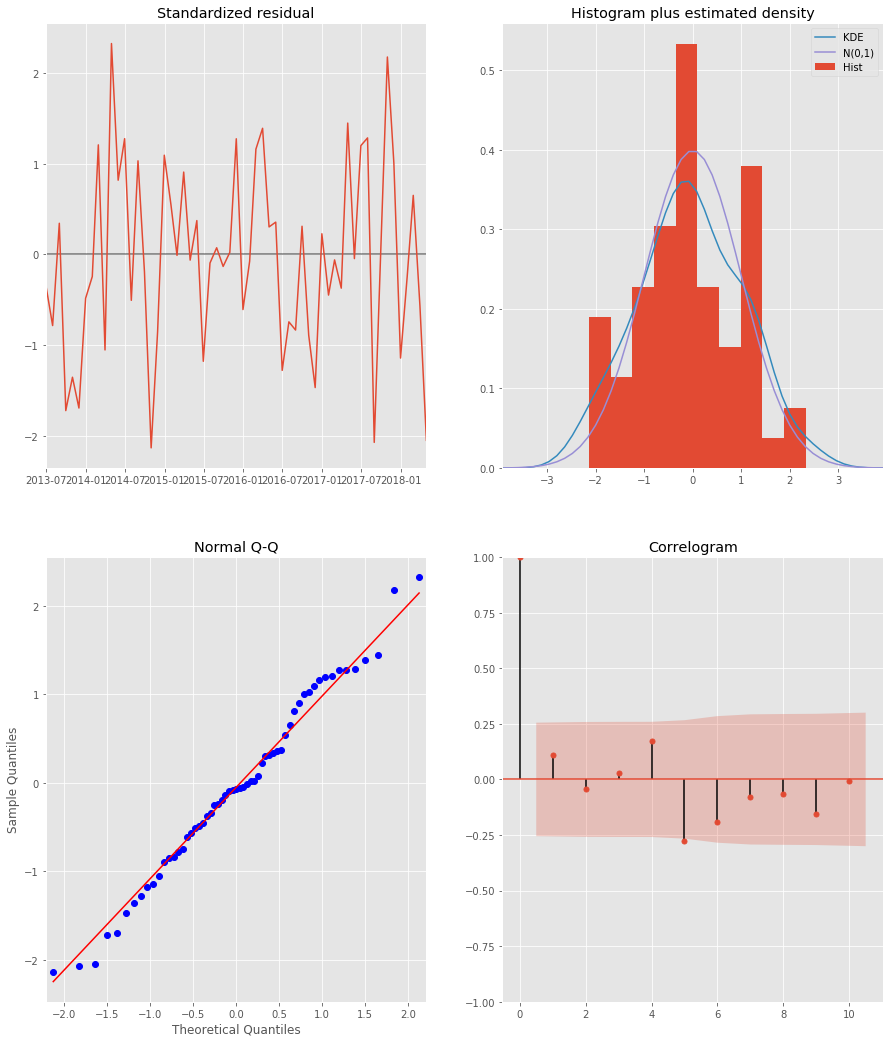

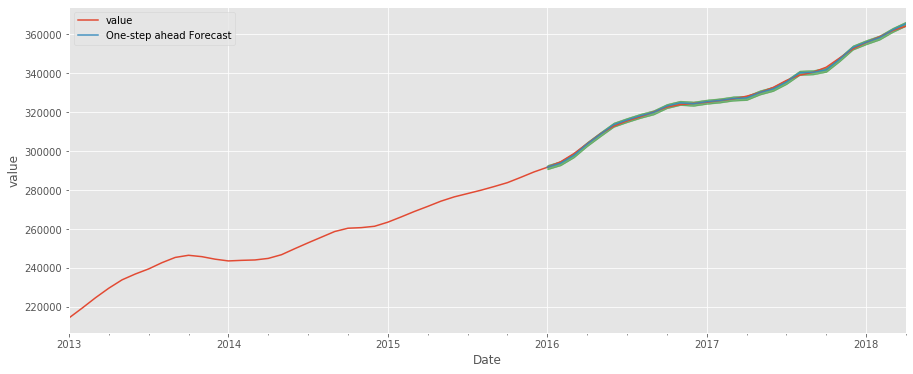

The Mean Squared Error of our forecasts is 401360.1


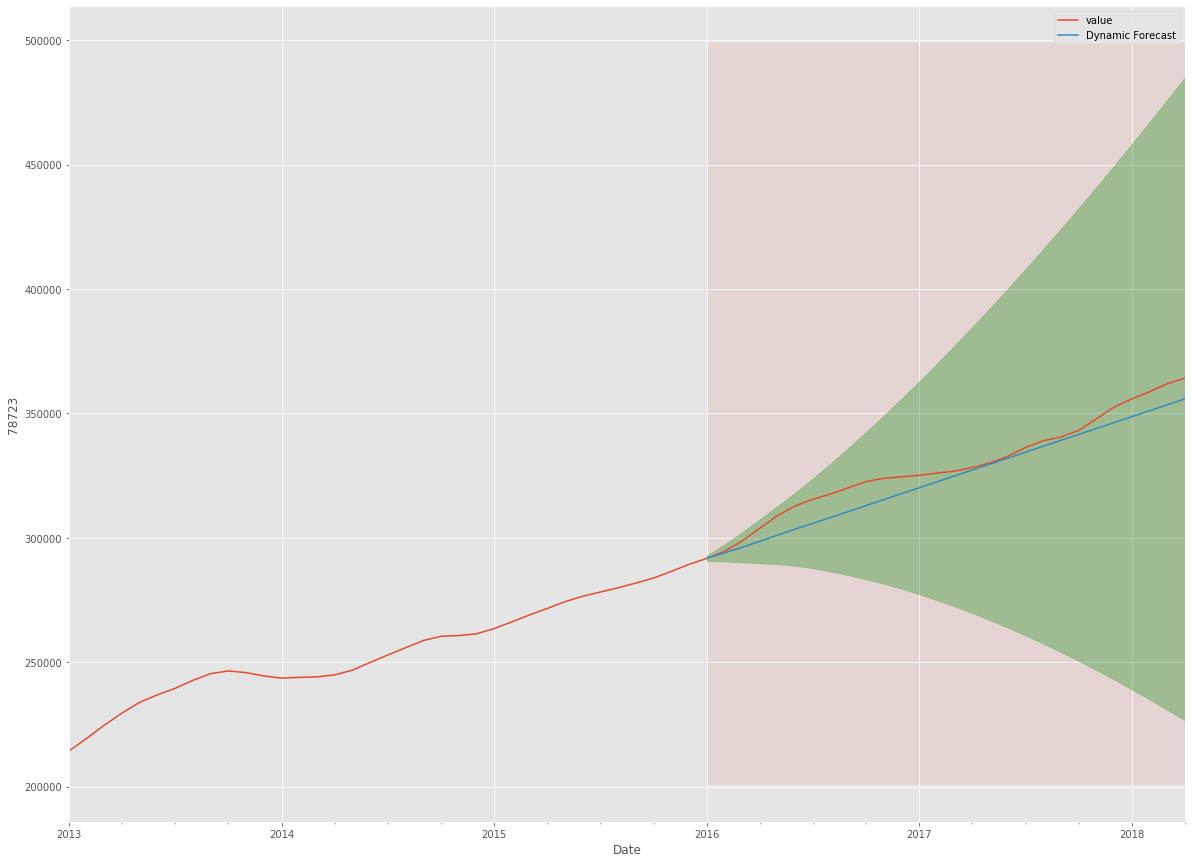

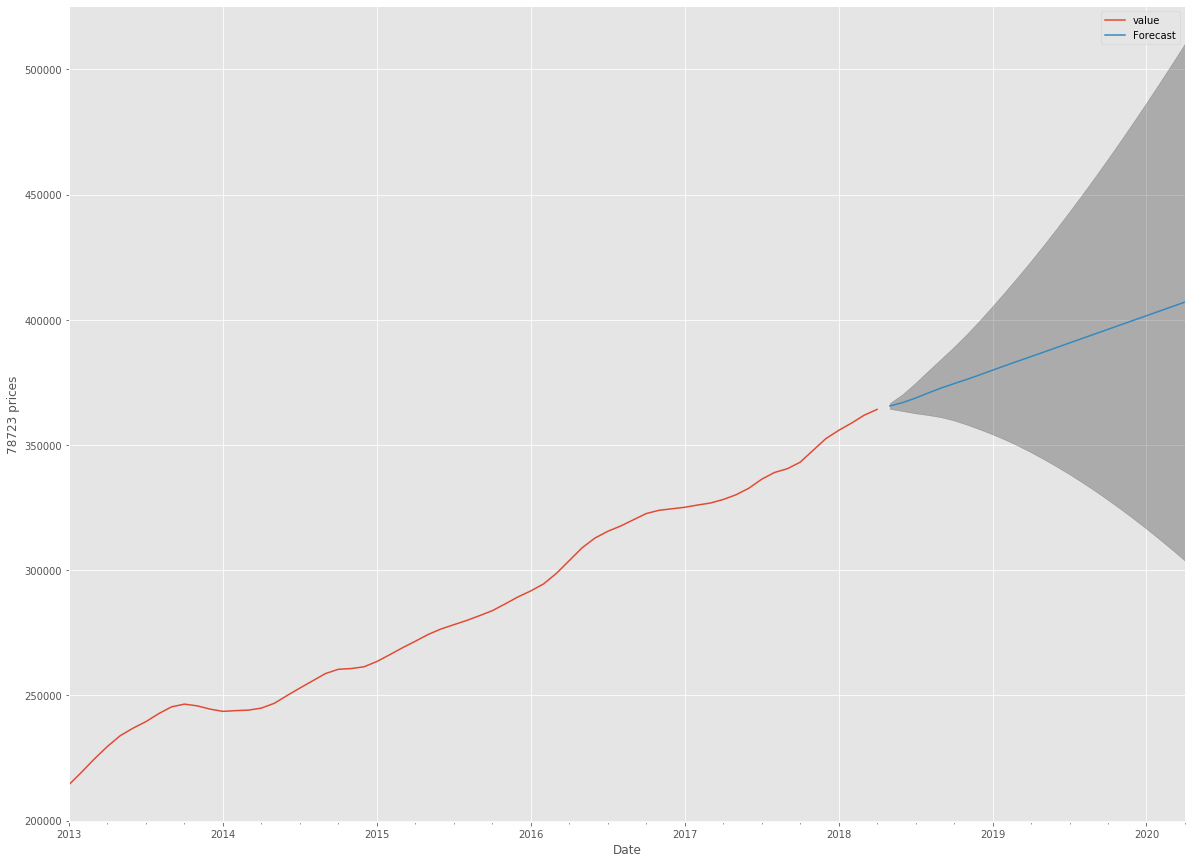

In [23]:
# acf, pacf
plot_acf_pacf(zip_78723, 78723)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78723, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78723['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78723_forecasted = pred.predicted_mean
zip_78723_truth = zip_78723['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78723_forecasted - zip_78723_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78723['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78723_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78723')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78723.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78723 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78723, roi_2] 

In [24]:
zip_78745 = zips_grouped.loc[78745]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78745,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1740.922762042507
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1671.7778352486691
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =2744.9758130889168
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1128.375942453339
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1037.7285705089373
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =963.7814307038184
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =937.5413164630934
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =912.5057660916826
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =891.2557016797143
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1058.4899207683968
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =991.5084567285132
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =954.3654253895658
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =952.8664026821685
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =930.4401422569058
ARIMA (1, 1, 2) x (0, 0, 0, 0)

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic           889.97
Name: 26, dtype: object

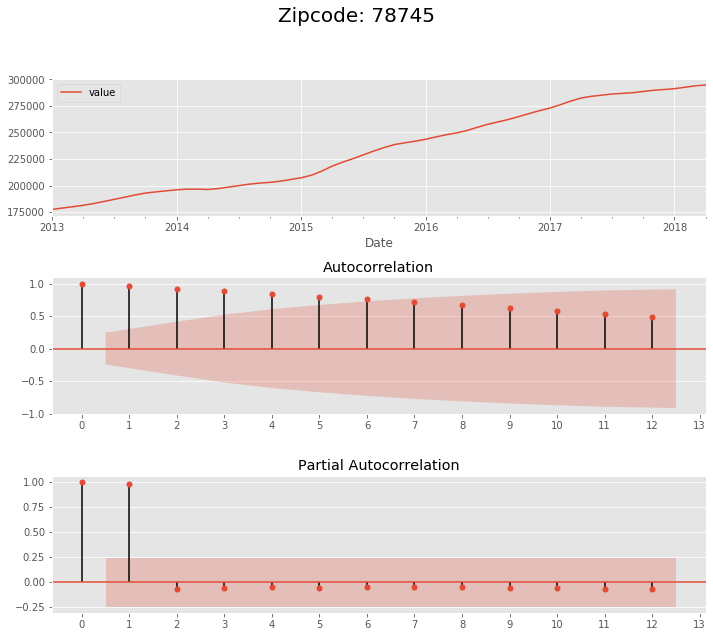

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3332      0.250      1.332      0.183      -0.157       0.823
ar.L2         -0.4815      0.132     -3.660      0.000      -0.739      -0.224
ma.L1          0.2479      0.250      0.992      0.321      -0.242       0.737
ma.L2          0.0346      0.121      0.286      0.775      -0.203       0.272
sigma2       1.81e+05   3.22e+04      5.614      0.000    1.18e+05    2.44e+05


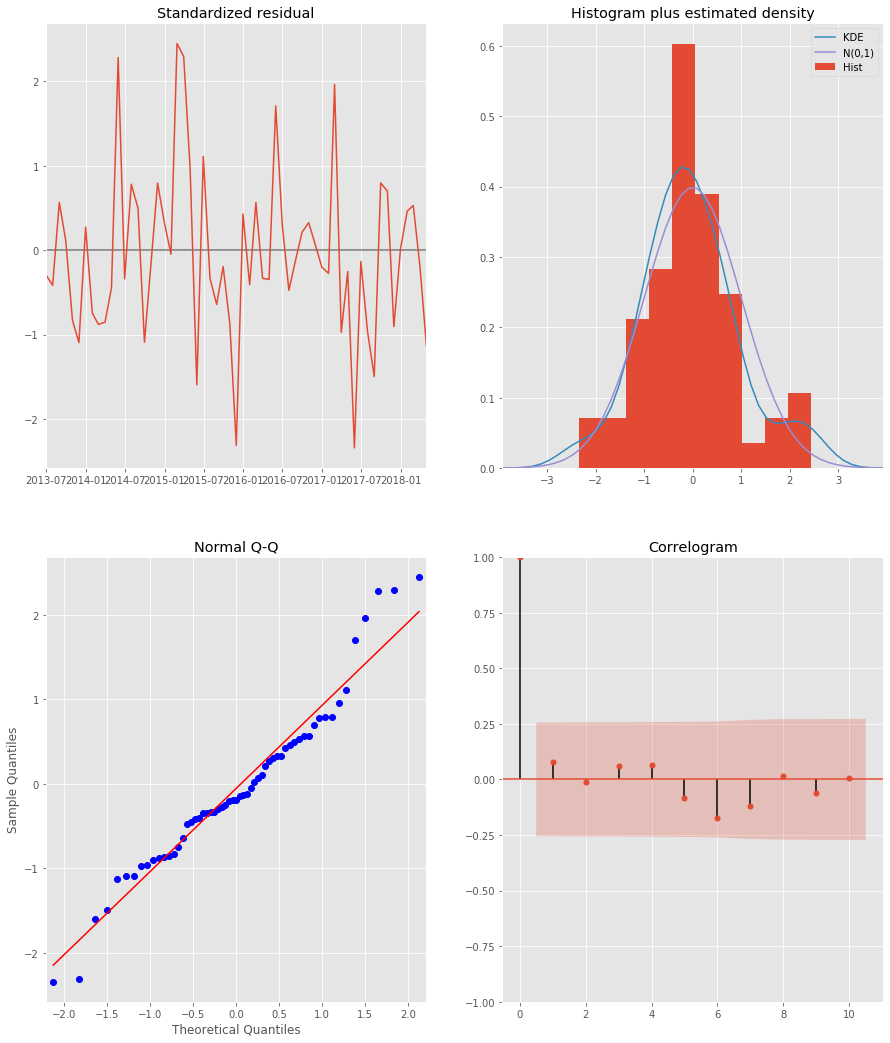

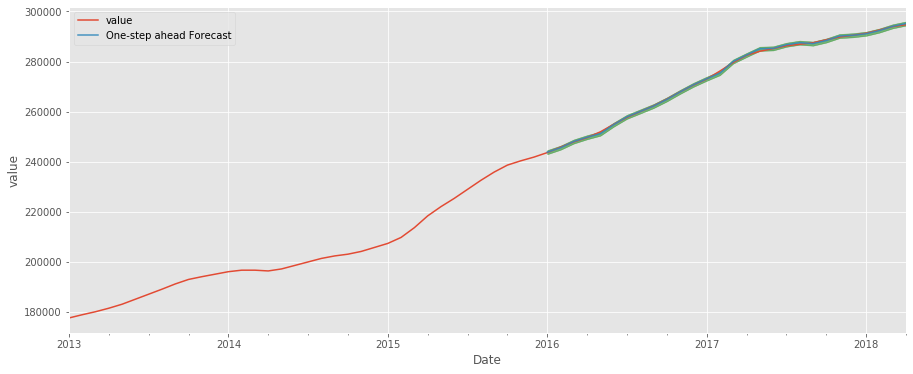

The Mean Squared Error of our forecasts is 139199.38


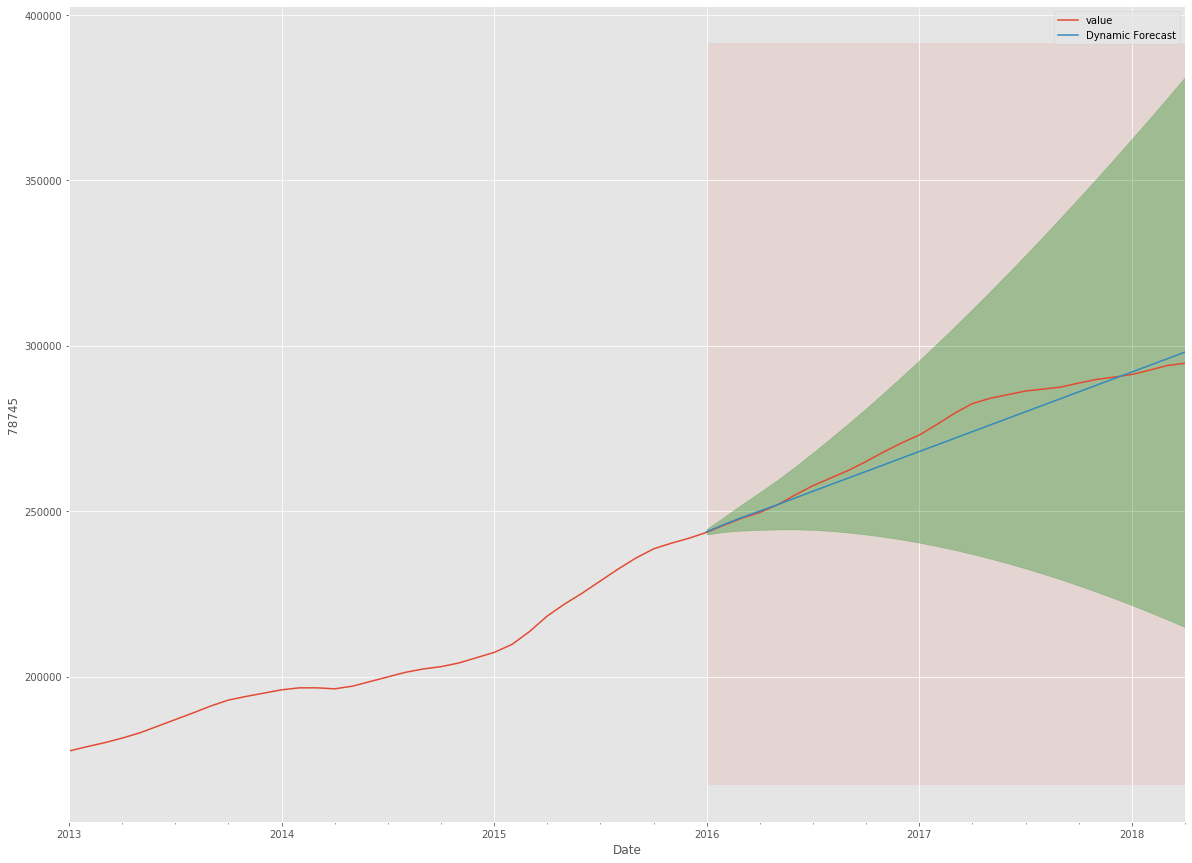

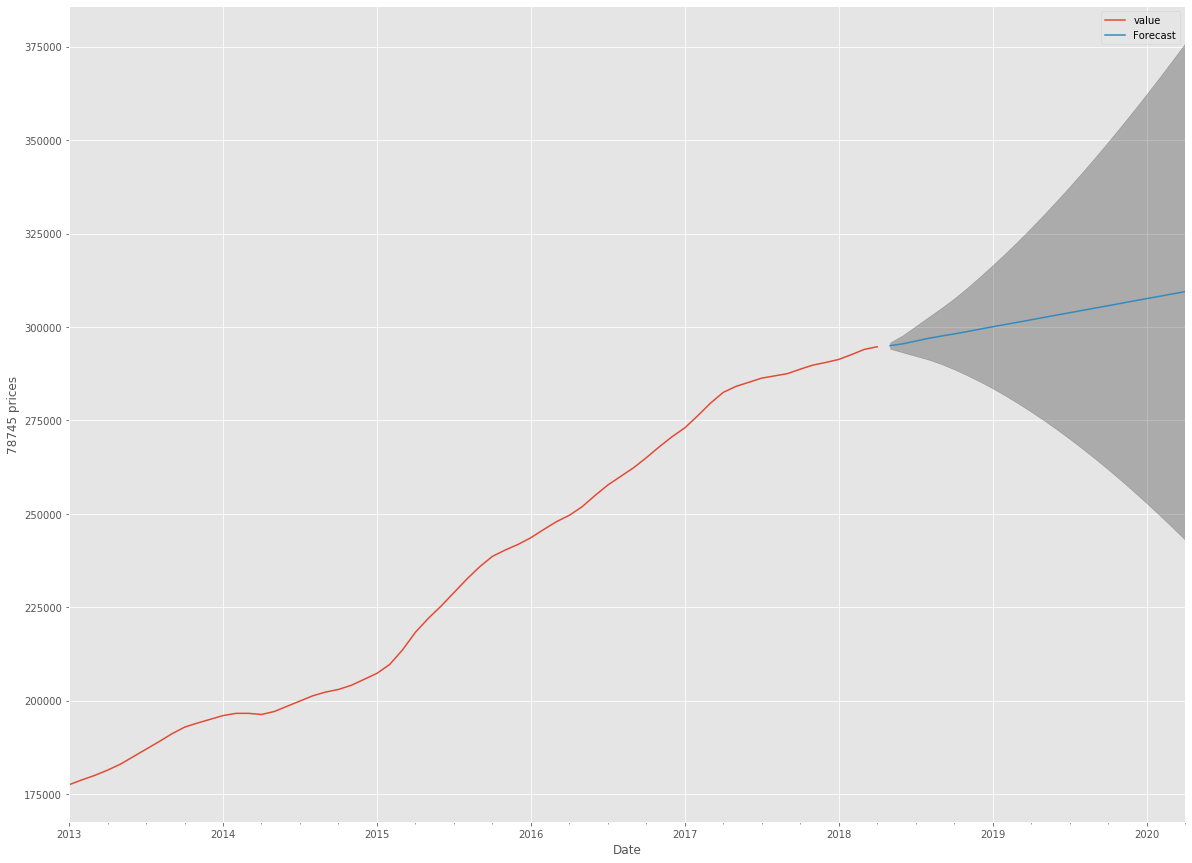

In [25]:
# acf, pacf
plot_acf_pacf(zip_78745, 78745)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78745, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78745['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78745_forecasted = pred.predicted_mean
zip_78745_truth = zip_78745['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78745_forecasted - zip_78745_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78745['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78745_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78745')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78745.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78745 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78745, roi_2] 

In [26]:
zip_78752 = zips_grouped.loc[78752]
# Run a grid with pdq and seasonal pdq parameters to determine the best AIC value
ans = []
for comb in pdq:
#     for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_78752,
                                            order=comb,
                                            seasonal_order=(0, 0, 0, 0),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, (0, 0, 0, 0), output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, (0, 0, 0, 0), output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1747.9002702525697
ARIMA (0, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1678.725448044979
ARIMA (0, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1644.893784180419
ARIMA (0, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1174.6989797691926
ARIMA (0, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1084.1103655626773
ARIMA (0, 1, 2) x (0, 0, 0, 0)12 : AIC Calculated =1014.6966748132329
ARIMA (0, 2, 0) x (0, 0, 0, 0)12 : AIC Calculated =1020.5274179627464
ARIMA (0, 2, 1) x (0, 0, 0, 0)12 : AIC Calculated =996.9595478332053
ARIMA (0, 2, 2) x (0, 0, 0, 0)12 : AIC Calculated =972.1075331352998
ARIMA (1, 0, 0) x (0, 0, 0, 0)12 : AIC Calculated =1167.3104723606007
ARIMA (1, 0, 1) x (0, 0, 0, 0)12 : AIC Calculated =1098.0910612787588
ARIMA (1, 0, 2) x (0, 0, 0, 0)12 : AIC Calculated =1061.5837213360576
ARIMA (1, 1, 0) x (0, 0, 0, 0)12 : AIC Calculated =1036.7682018361604
ARIMA (1, 1, 1) x (0, 0, 0, 0)12 : AIC Calculated =1014.3605542028041
ARIMA (1, 1, 2) x (0, 0,

pdq        (2, 2, 2)
pdqs    (0, 0, 0, 0)
aic          967.477
Name: 26, dtype: object

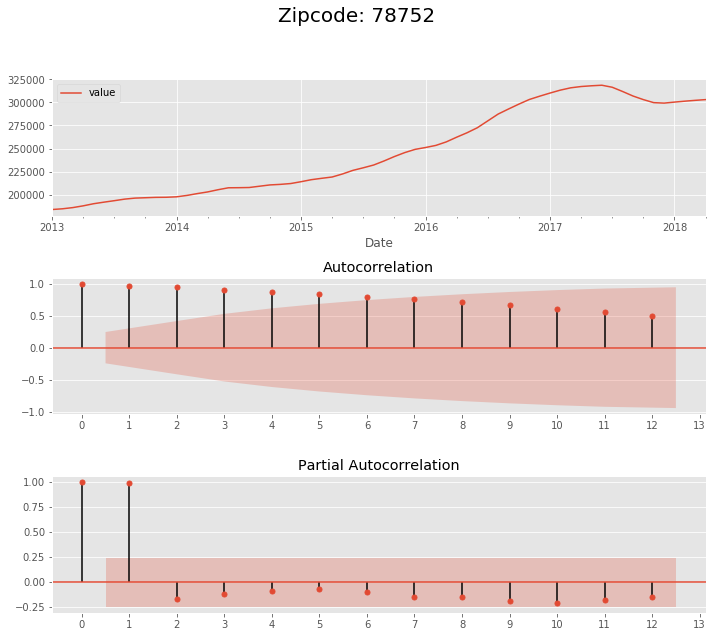

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6009      0.100     -5.992      0.000      -0.797      -0.404
ar.L2         -0.2352      0.031     -7.523      0.000      -0.297      -0.174
ma.L1          1.5016      0.139     10.818      0.000       1.230       1.774
ma.L2          0.8453      0.105      8.024      0.000       0.639       1.052
sigma2       7.54e+05   1.18e+05      6.388      0.000    5.23e+05    9.85e+05


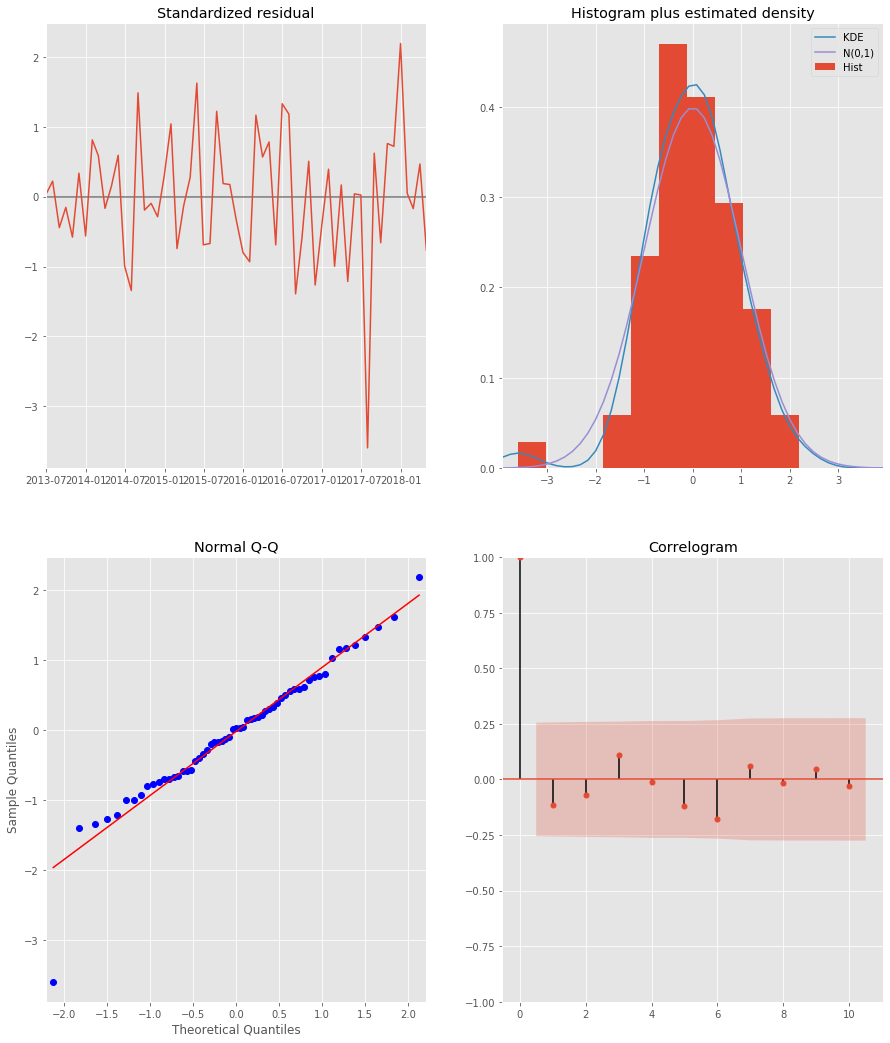

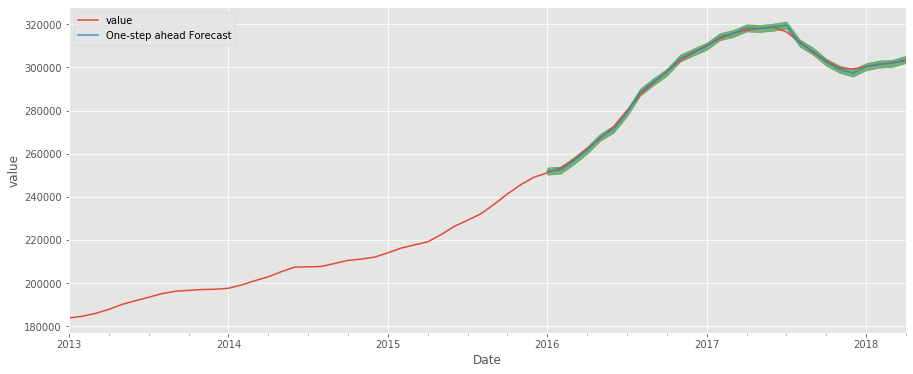

The Mean Squared Error of our forecasts is 920852.25


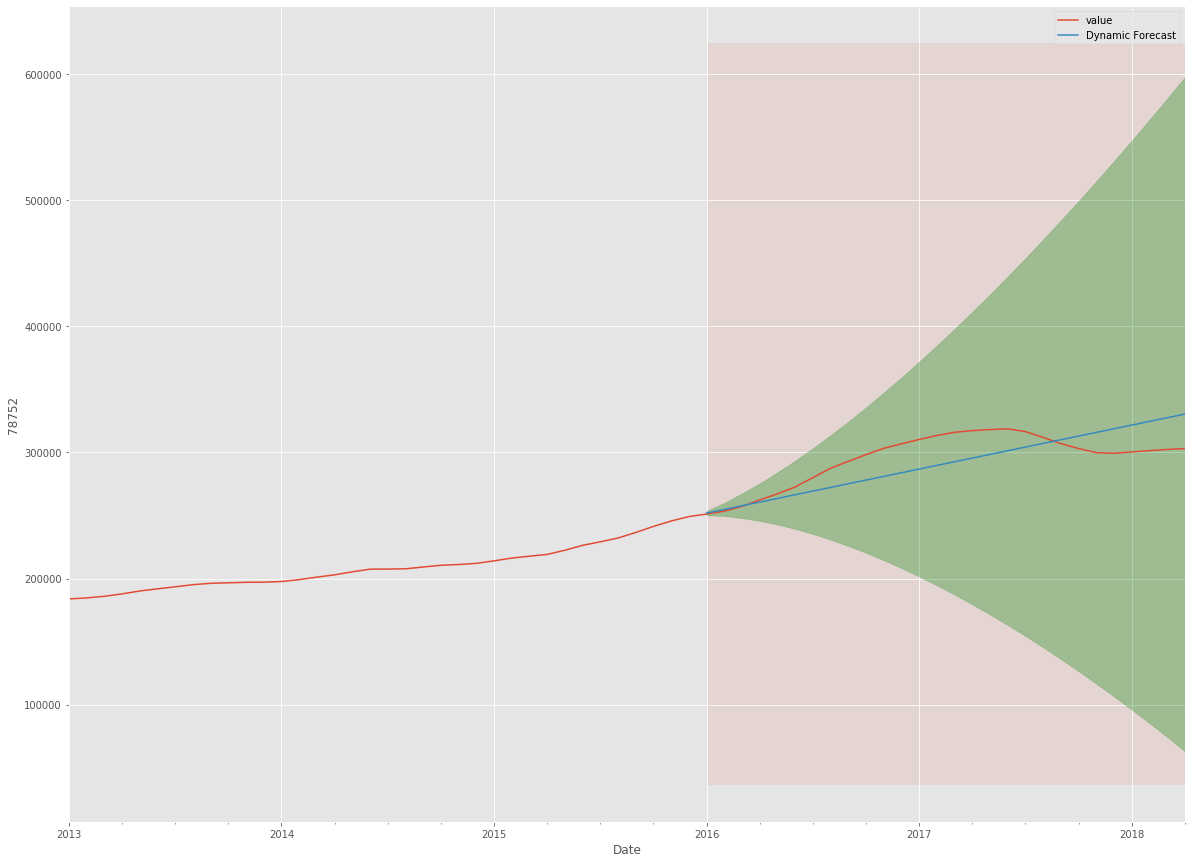

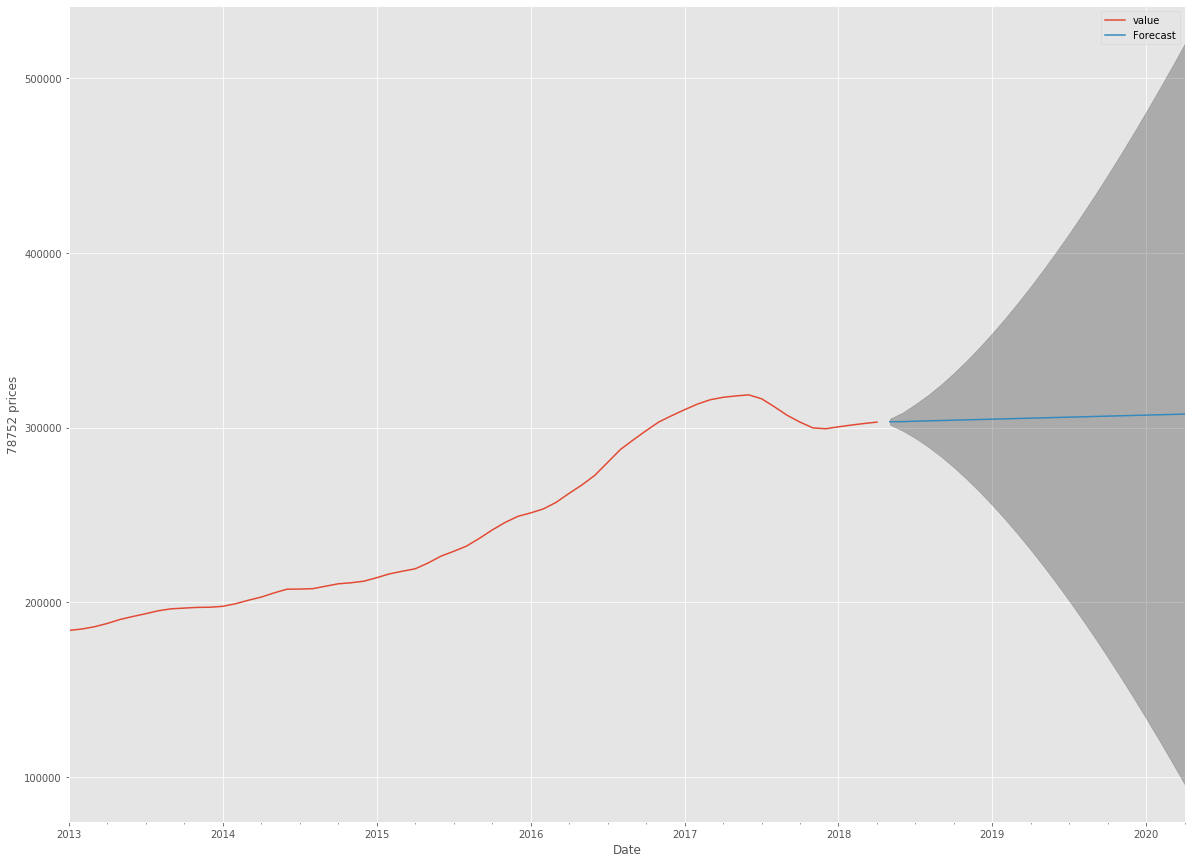

In [27]:
# acf, pacf
plot_acf_pacf(zip_78752, 78752)
plt.show()

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_78752, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6
ax = zip_78752['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

# Get the real and predicted values
zip_78752_forecasted = pred.predicted_mean
zip_78752_truth = zip_78752['value']['2016-01-31':]

# Compute the mean square error
mse = ((zip_78752_forecasted - zip_78752_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.

ax = zip_78752['2013':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), zip_78752_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('78752')

plt.legend()
plt.show()

# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_78752.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('78752 prices')

plt.legend()
plt.show()

pred_conf['mean'] = prediction.predicted_mean
roi_2 = (pred_conf.iloc[23][2] - pred_conf.iloc[0][2])/pred_conf.iloc[0][2] * 100
roi_2

pred_roi_df.loc[len(pred_roi_df.index)] = [78752, roi_2] 

In [28]:
pred_roi_df

,zipcode,roi_2
0,78702.0,-2.475796
1,78758.0,19.882925
2,78702.0,11.528812
3,78744.0,10.365843
4,78741.0,21.187219
5,78753.0,15.249987
6,78724.0,-0.928001
7,78723.0,11.340899
8,78745.0,4.899813
9,78752.0,1.437872


In [29]:
pred_roi_sorted_df = pred_roi_df.sort_values(['roi_2'], ascending=False)
pred_roi_sorted_df

,zipcode,roi_2
4,78741.0,21.187219
1,78758.0,19.882925
5,78753.0,15.249987
2,78702.0,11.528812
7,78723.0,11.340899
3,78744.0,10.365843
8,78745.0,4.899813
9,78752.0,1.437872
6,78724.0,-0.928001
0,78702.0,-2.475796
